# TP1 - Grupo 4 - VAR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
import scipy.stats
import pylab
import statsmodels.tsa.stattools as tsa
import pmdarima as pm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

##########################################################################################
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import ADFTest
from statsmodels.tsa.api import VAR
##########################################################################################

from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,10)})

# Series
## a) Pasajeros

In [2]:
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Pasajeros_TP.csv'
pasajeros_d = pd.read_csv(url)
pasajeros_d.rename({'FechaRecaudacion': 'fecha', 'Cantidad_Pasajeros': 'pas'}, axis=1, inplace=True)
pasajeros_d = pasajeros_d[(pasajeros_d['fecha'] >= '2021-10-01') & (pasajeros_d['fecha'] <= '2023-10-30')]
# Para la fecha jueves 13 de octubre del 2022, se observa el valor de 1 y para corregir este dato se optó por sacar el promedio de los dos dias posteriores y el valor del día anterior.
# Además se agregan las observaciones que corresponden a los días 2022-05-17, 2022-10-12, 2023-06-13 y 2023-06-22 con el valor de 1, posteriormente se reemplaza este valor por el promedio de los dos dias posteriores y el valor del día anterior.
# Agregar fechas faltantes
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'pas': 1},
                                     {'fecha': '2022-10-12', 'pas': 1},
                                     {'fecha': '2023-06-13', 'pas': 1},
                                     {'fecha': '2023-06-22', 'pas': 1}])
pasajeros_d = pd.concat([pasajeros_d, nuevas_observaciones], ignore_index=True)
# Ordenar el DataFrame por la columna de fechas
pasajeros_d = pasajeros_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
pasajeros_d = pasajeros_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
pasajeros_d['fecha'] = pd.to_datetime(pasajeros_d['fecha'], dayfirst=True, format="%Y-%m-%d")
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_17 = round(average_value_17, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_17
# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_12 = round(average_value_12, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_12
# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_13 = round(average_value_13, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_13
# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_6 = round(average_value_6, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_6
# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_22 = round(average_value_22, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_22
# Formato diario
pasajeros_d.set_index('fecha', inplace=True)

pasajeros_d = pasajeros_d.asfreq('d')
pasajeros_d = pasajeros_d['pas']
pasajeros_d.describe()

count       760.000000
mean     175952.678947
std       82497.043937
min        5582.000000
25%      106144.500000
50%      178343.000000
75%      249701.000000
max      319953.000000
Name: pas, dtype: float64

In [48]:
pas_diff=pasajeros_d.copy()
pas_diff=pas_diff.diff(periods = 1)
pas_diff = pas_diff.dropna()

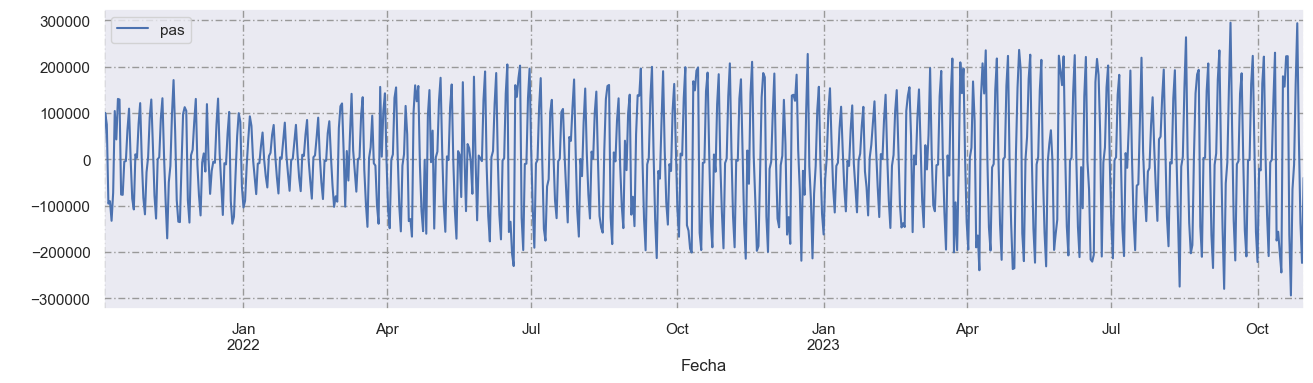

In [3]:
# Funcion para graficar

def graficar(serie, titulo="", xlabel="Fecha", ylabel=" "):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    serie.plot()
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))
    
# Para remover la estacionalidad semanal,
# Hacemos una diferencia semanal y en el grafico ya no observamos un patron repetitivo

# Diferenciar la serie
pas_diff_4=pasajeros_d.copy()
pas_diff_4=pas_diff_4.diff(periods = 4)
pas_diff_4 = pas_diff_4.dropna()
graficar(pas_diff_4)

## b) Consumo

In [3]:
# Consumo
url = 'https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Consumo_TP.csv'
raw_csv_data = pd.read_csv(url, sep=',', decimal='.')
consumo_d = raw_csv_data.copy()
consumo_d = consumo_d[(consumo_d['Fecha'] >= '2021-10-01') & (consumo_d['Fecha'] <= '2023-10-30')]
consumo_d = consumo_d.loc[consumo_d.Consumo>0]
consumo_d.rename({'Fecha': 'fecha', 'Consumo': 'con'}, axis=1, inplace=True)
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'con': 1},
                                     {'fecha': '2022-10-12', 'con': 1},
                                     {'fecha': '2022-10-13', 'con': 1},
                                     {'fecha': '2023-06-13', 'con': 1},
                                     {'fecha': '2023-06-22', 'con': 1}])
consumo_d = pd.concat([consumo_d, nuevas_observaciones], ignore_index=True)

# Ordenar el DataFrame por la columna de fechas
consumo_d = consumo_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
consumo_d = consumo_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
consumo_d['fecha'] = pd.to_datetime(consumo_d['fecha'], dayfirst=True, format="%Y-%m-%d")
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_17

# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_12

# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_13

# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_6

# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_22

# Formato diario
consumo_d.set_index('fecha', inplace=True)

consumo_d = consumo_d.asfreq('d')
consumo_d = consumo_d['con']
consumo_d.describe()

count    760.000000
mean      46.018249
std        3.446071
min       21.671538
25%       44.059896
50%       46.227106
75%       48.002559
max       55.802864
Name: con, dtype: float64

In [49]:
# Diferenciar la serie
con_diff=consumo_d.copy()
con_diff=con_diff.diff(periods = 1)
con_diff = con_diff.dropna()

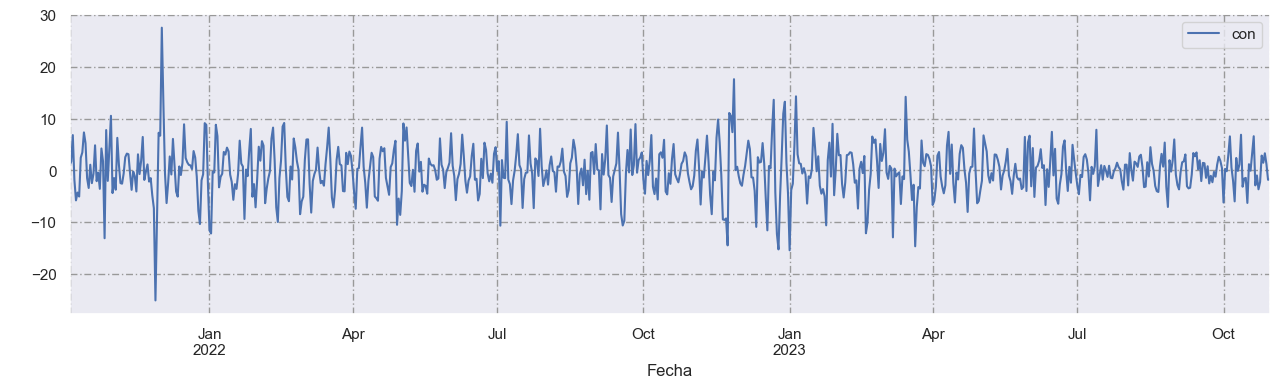

In [5]:
# Diferenciar la serie
con_diff_4=consumo_d.copy()
con_diff_4=con_diff_4.diff(periods = 4)
con_diff_4 = con_diff_4.dropna()
graficar(con_diff_4)

## c) Kilómetros

In [4]:
# KM
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Kilometros_TP.csv'
raw_csv_data = pd.read_csv(url, sep=',', decimal='.')
km_d = raw_csv_data.copy()
km_d = km_d[(km_d['Fecha'] >= '2021-10-01') & (km_d['Fecha'] <= '2023-10-30')]

km_d.rename({'Fecha': 'fecha', 'KM': 'km'}, axis=1, inplace=True)
nuevas_observaciones = pd.DataFrame([{'fecha': '2023-06-22', 'km': 1}])
km_d = pd.concat([km_d, nuevas_observaciones], ignore_index=True)
km_d = km_d.sort_values(by=['fecha'], ascending=True)
km_d = km_d.reset_index(drop=True)
# Convertir la columna 'Fecha' a tipo datetime
km_d['fecha'] = pd.to_datetime(km_d['fecha'], dayfirst=True, format="%Y-%m-%d")
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = km_d.index[km_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_17

# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = km_d.index[km_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_12

# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = km_d.index[km_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_13

# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = km_d.index[km_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_6

# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = km_d.index[km_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_22

# Formato diario
km_d.set_index('fecha', inplace=True)

km_d = km_d.asfreq('d')
km_d = km_d['km']
km_d.describe()

count       760.000000
mean      73977.713023
std       23424.039351
min       17554.422000
25%       52696.933750
50%       75397.900000
75%       97051.868000
max      105834.661000
Name: km, dtype: float64

In [9]:
consumo_d.describe()

count    760.000000
mean      46.018249
std        3.446071
min       21.671538
25%       44.059896
50%       46.227106
75%       48.002559
max       55.802864
Name: con, dtype: float64

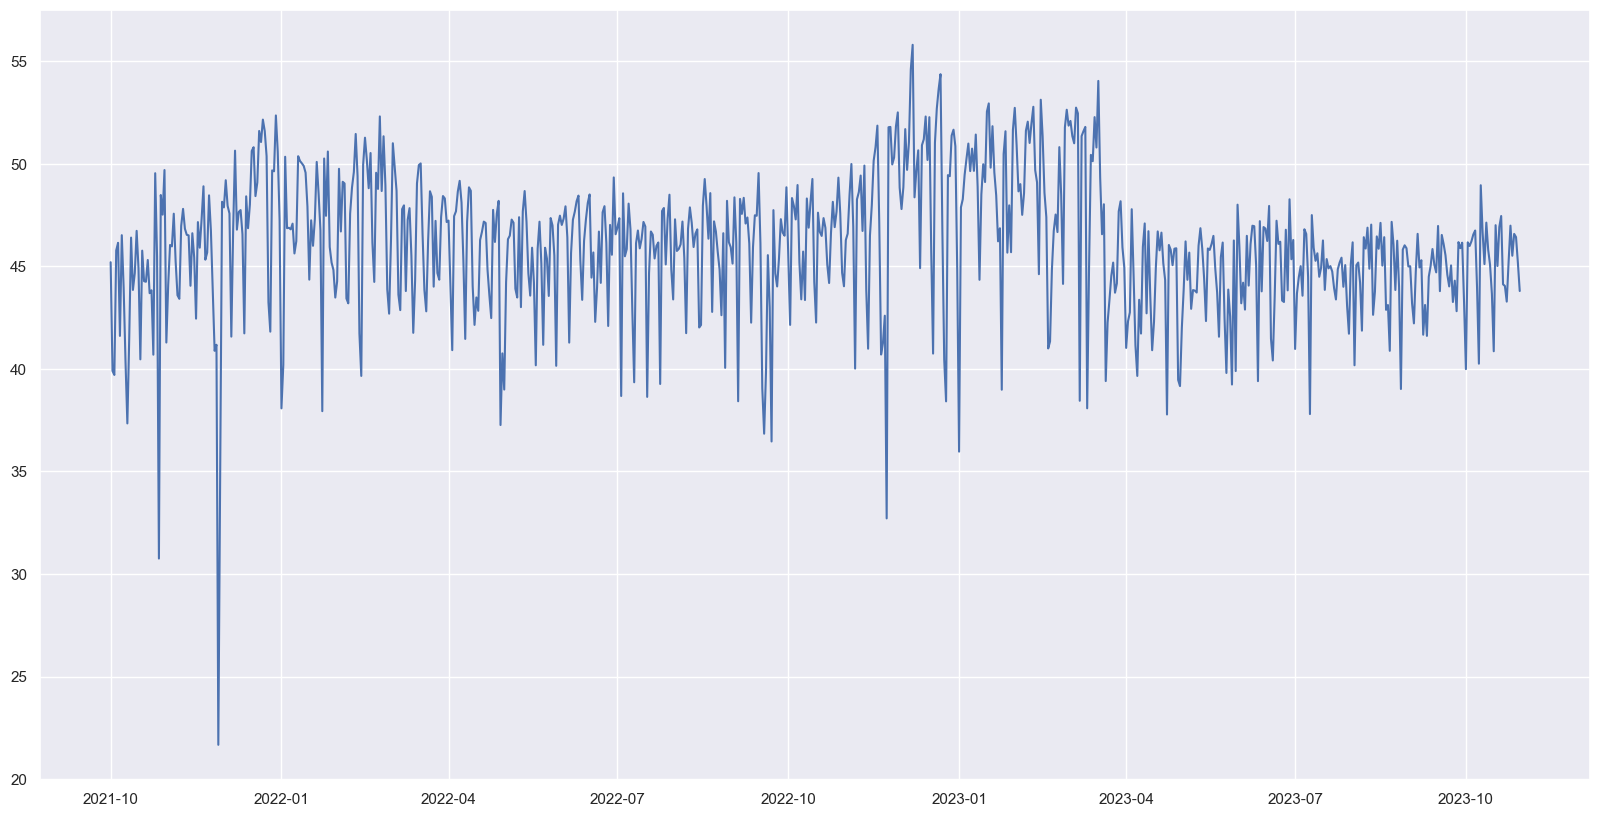

In [7]:
plt.plot(consumo_d)


In [51]:
# Diferenciar la serie
km_diff=km_d.copy()
km_diff=km_diff.diff(periods = 1)
km_diff = km_diff.dropna()

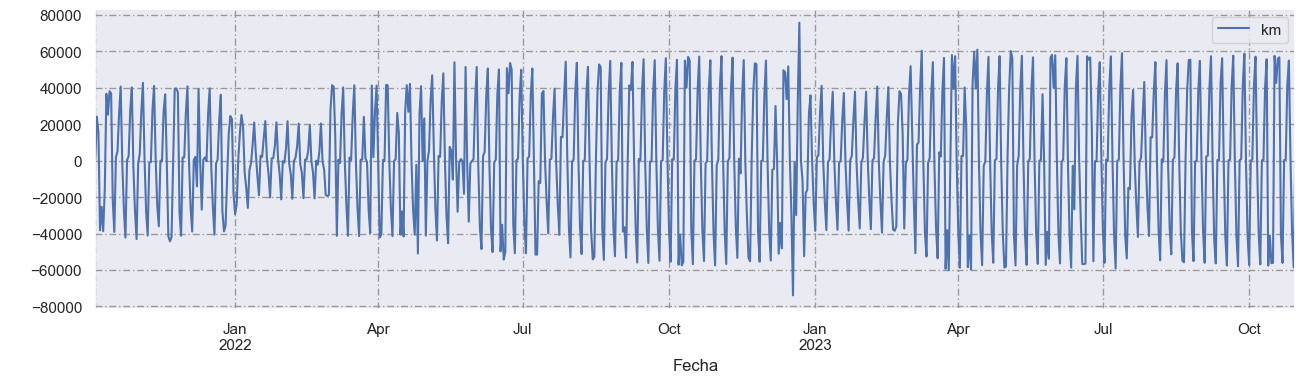

In [7]:
# Diferenciar la serie
km_diff_4=km_d.copy()
km_diff_4=km_diff_4.diff(periods = 4)
km_diff_4 = km_diff_4.dropna()
graficar(km_diff_4)

###########################################

# Sin diferenciar las series

In [74]:
# Dataframe de las tres series que se utilizarán para el modelo VAR
serieVAR=pd.concat([consumo_d, km_d, pasajeros_d], axis=1)

In [15]:
serieVAR.head()

con         km     pas
fecha                                   
2021-10-01  45.201497  73177.190  163933
2021-10-02  39.899719  49300.256   71862
2021-10-03  39.705724  34024.972   41802
2021-10-04  45.777167  73453.515  159940
2021-10-05  46.147136  73722.635  170473

In [16]:
# Separacion Train/Test

# Seleccion de train
train = serieVAR[:-14]

# Seleccionamos de test
test = serieVAR[-14:]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train,"\n\n", test)

                  con          km     pas
fecha                                    
2021-10-01  45.201497   73177.190  163933
2021-10-02  39.899719   49300.256   71862
2021-10-03  39.705724   34024.972   41802
2021-10-04  45.777167   73453.515  159940
2021-10-05  46.147136   73722.635  170473
...               ...         ...     ...
2023-10-12  47.132878  100921.656  319953
2023-10-13  45.812691   44550.463  123015
2023-10-14  45.078861   60757.829  142922
2023-10-15  43.659297   45225.920   81588
2023-10-16  40.860755   44817.861   75418

[746 rows x 3 columns] 

                   con          km     pas
fecha                                    
2023-10-17  47.007409  102048.735  302086
2023-10-18  45.018029  103438.338  299698
2023-10-19  46.920585  101205.310  303919
2023-10-20  47.454229  101546.738  297951
2023-10-21  44.124254   61042.359  138731
2023-10-22  44.044581   47321.881    5582
2023-10-23  43.281193  101572.556  239320
2023-10-24  45.218363  101884.237  286480
2023-10

Criterio de Granger: La hipótesis nula supone que el pasado de una variable no proporciona información adicional para predecir la otra variable más allá de lo que ya se puede predecir utilizando solo su propio pasado

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests

In [18]:
# P-valores menores al nivel de significancia (0.05) implica que la hipotesis nula (X no causa Y) puede rechazarse.
# testgr: Es el tipo de prueba que se utilizará para evaluar la causalidad de Granger. Por defecto, se utiliza 'ssr_chi2test', que es una prueba basada en chi-cuadrado,

def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):


    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# se agrega '_x' al final de los nombres de las columnas para indicar que son las variables "causantes" y '_y' al final de los nombres de las filas para indicar que son las variables "afectadas".

# H0: La serie temporal X no causa grangerianamente la serie temporal Y.

# H1: La serie temporal X causa grangerianamente la serie temporal Y

In [108]:
testgr = 'ssr_chi2test'
grangers_causation_matrix(train, variables = train.columns, maxlag=1)

con_x      km_x         pas_x
con_y  1.000000  0.000001  4.706131e-07
km_y   0.018692  1.000000  1.690999e-01
pas_y  0.025639  0.017244  1.000000e+00

Interpretación: Basándonos en el resultado de la prueba de causalidad de Granger, podemos afirmar que los valores pasados de Serie A (con un rezagos máximos de 10 períodos) proporcionan información estadísticamente significativa para predecir los valores futuros de Serie B. Esto sugiere una relación de causalidad grangeriana de Serie A hacia Serie B en este contexto específico.

In [20]:
from statsmodels.tsa.api import VAR

In [21]:
model = VAR(train.diff()[1:])

-AIC (Akaike Information Criterion)

-BIC (Bayesian Information Criterion)

-FPE (Final Prediction Error)

-HQIC (Hannan-Quinn Information Criterion)


A continuación se utiliza el método select_order del modelo VAR (model) para seleccionar el orden adecuado del modelo VAR basado en criterios estadísticos. El parámetro maxlags se establece en 70, lo que significa que el código considerará modelos VAR con hasta 70 rezagos.

In [22]:
x = model.select_order(maxlags=30)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [23]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, Dec, 2023
Time:                     18:57:23
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    40.5953
Nobs:                     739.000    HQIC:                   40.3771
Log likelihood:          -17957.5    FPE:                2.99281e+17
AIC:                      40.2401    Det(Omega_mle):     2.77335e+17
--------------------------------------------------------------------
Results for equation con
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.002379         0.104802            0.023           0.982
L1.con        -0.607842         0.038959          -15.602           0.000
L1.km         -0.000081         0.000025           -3.314           0.001
L1.pas         0

In [24]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

6


array([[4.51096263e+01, 1.01517207e+05, 2.84205000e+05],
       [4.71328780e+01, 1.00921656e+05, 3.19953000e+05],
       [4.58126907e+01, 4.45504630e+04, 1.23015000e+05],
       [4.50788608e+01, 6.07578290e+04, 1.42922000e+05],
       [4.36592972e+01, 4.52259200e+04, 8.15880000e+04],
       [4.08607546e+01, 4.48178610e+04, 7.54180000e+04]])

In [25]:
# Forecast
n_forecast = 14
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast)
df_forecast = pd.DataFrame(fc, index=serieVAR.index[-n_forecast:], columns=serieVAR.columns + '_1d')
df_forecast

con_1d          km_1d         pas_1d
fecha                                               
2023-10-17 -129.410232 -296772.788540 -907359.027753
2023-10-18  -14.269317   27727.721208   88354.029303
2023-10-19   15.960335   83426.898987  289448.967082
2023-10-20   14.831703   25793.020754   53578.833152
2023-10-21   16.759753   51309.477149  192900.676612
2023-10-22   15.356351   72443.813883  247578.154324
2023-10-23   13.251238   -4404.259955   40698.769945
2023-10-24  -38.356582 -203915.918321 -717868.096018
2023-10-25  -11.441696  -16082.871572  -89290.040957
2023-10-26    6.230496   68774.948932  227491.684734
2023-10-27    4.798704   24217.276426   74727.525751
2023-10-28    7.637221   50861.651104  180782.128428
2023-10-29    9.154235   71561.458057  262817.814021
2023-10-30    3.456833  -14827.995002  -17687.871991

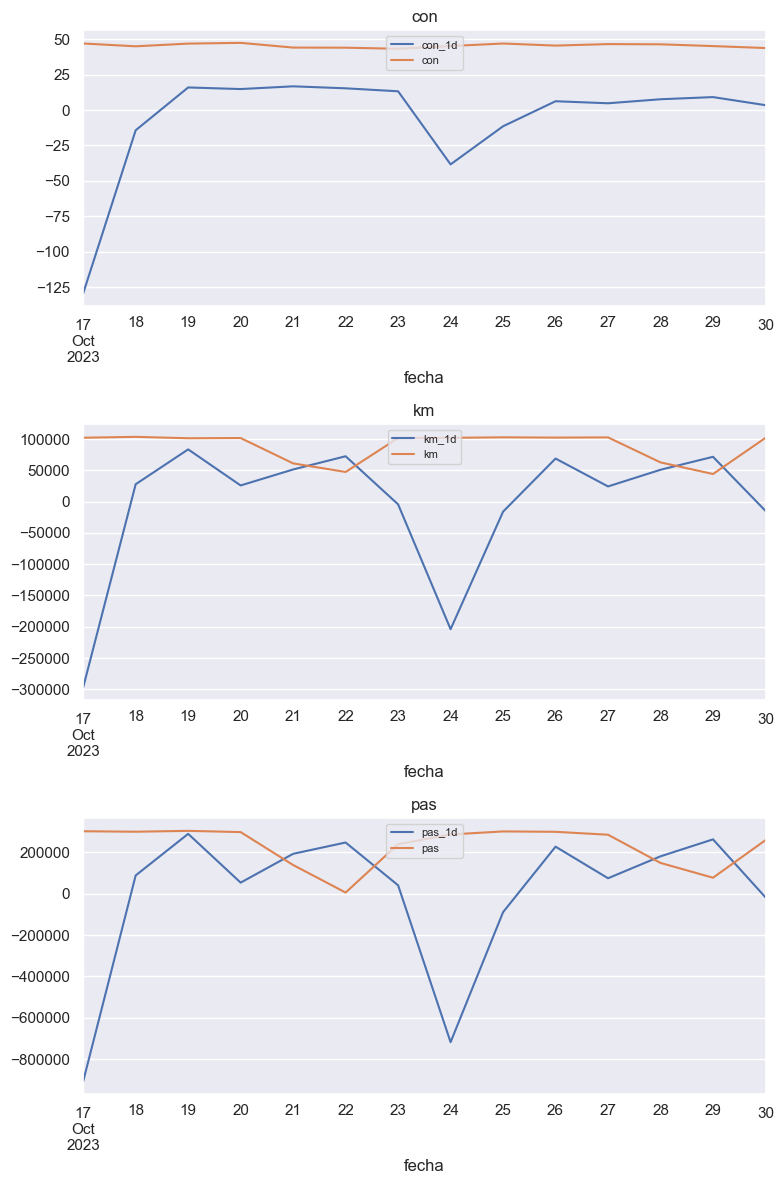

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8, 12))

for i, (col, ax) in enumerate(zip(serieVAR.columns, axes.flatten())):
    df_forecast[col+'_1d'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test[col][-n_forecast:].plot(legend=True, ax=ax)
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.legend(fontsize="8", loc='upper center')

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficas
plt.show()

In [35]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [36]:
df_results = invert_transformation(train, df_forecast, second_diff=False)
df_results.loc[:, ['con_forecast', 'km_forecast', 'pas_forecast']]

con_forecast    km_forecast   pas_forecast
fecha                                                 
2023-10-17    -88.549478 -251954.927540 -831941.027753
2023-10-18   -102.818795 -224227.206332 -743586.998450
2023-10-19    -86.858460 -140800.307346 -454138.031368
2023-10-20    -72.026758 -115007.286592 -400559.198215
2023-10-21    -55.267005  -63697.809442 -207658.521603
2023-10-22    -39.910654    8746.004440   39919.632721
2023-10-23    -26.659415    4341.744485   80618.402666
2023-10-24    -65.015998 -199574.173836 -637249.693351
2023-10-25    -76.457694 -215657.045408 -726539.734309
2023-10-26    -70.227198 -146882.096475 -499048.049575
2023-10-27    -65.428493 -122664.820049 -424320.523824
2023-10-28    -57.791272  -71803.168945 -243538.395396
2023-10-29    -48.637037    -241.710888   19279.418625
2023-10-30    -45.180205  -15069.705890    1591.546634

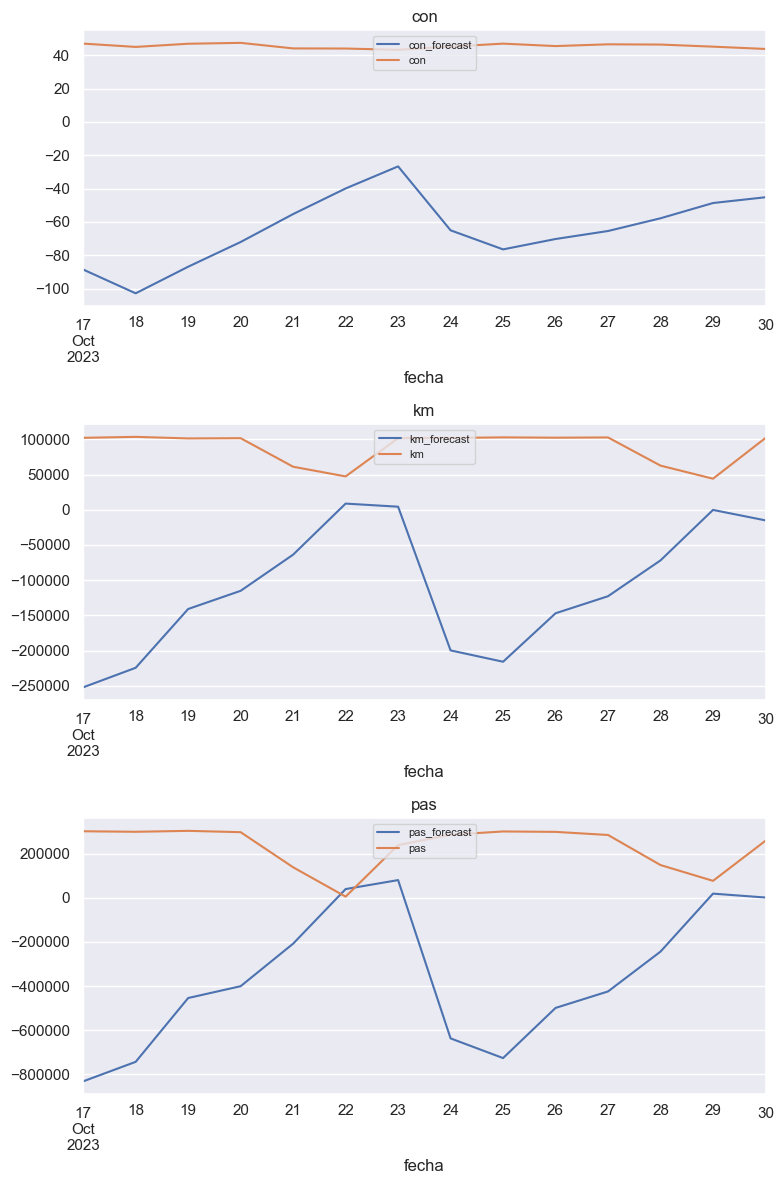

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8, 12))

for i, (col, ax) in enumerate(zip(serieVAR.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test[col][-n_forecast:].plot(legend=True, ax=ax)
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.legend(fontsize="8", loc='upper center')

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficas
plt.show()

Análisis de residuos:

In [38]:
print(model_fitted.summary()._resid_info())

Correlation matrix of residuals
            con        km       pas
con    1.000000  0.344805  0.380855
km     0.344805  1.000000  0.950930
pas    0.380855  0.950930  1.000000




Residuos correlacionados. En este caso, parece haber correlaciones positivas significativas entre los residuos de las tres variables, lo que sugiere que podría haber relaciones de corto plazo entre estas variables en el modelo VAR.

In [40]:
residuos_analisis= model_fitted.resid
residuos_analisis

con            km            pas
fecha                                            
2021-10-08 -2.091780 -26516.970422  -77633.086930
2021-10-09 -3.167513   6289.730399    9077.922554
2021-10-10 -3.014904  -6985.520144  -20166.610060
2021-10-11 -1.212311 -30150.046796  -94570.854127
2021-10-12  1.953844   7088.440213   16422.913494
...              ...           ...            ...
2023-10-12  0.943783  -3716.775317   15830.010190
2023-10-13 -1.519716 -51831.844605 -170000.042546
2023-10-14  0.344615  10421.557186   15757.132807
2023-10-15  0.561977 -13300.963744  -55265.119883
2023-10-16 -5.411587 -43579.868054 -168039.626995

[739 rows x 3 columns]

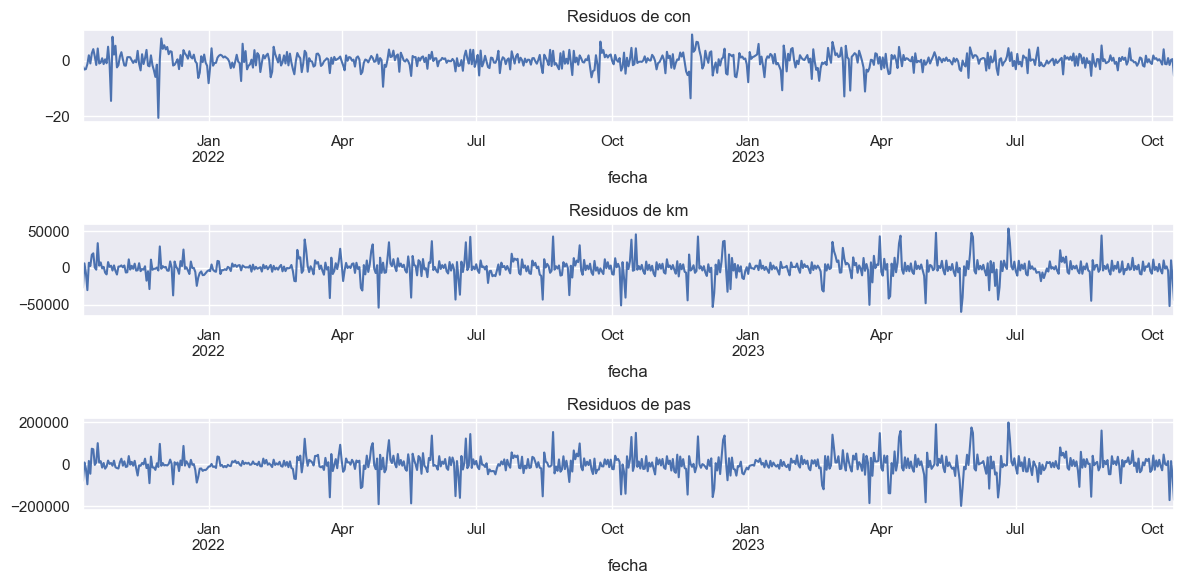

In [41]:
fig, axs = plt.subplots(nrows=residuos_analisis.shape[1], figsize=(12, 6))

for i, col in enumerate(residuos_analisis.columns):
    residuos_analisis[col].plot(ax=axs[i])
    axs[i].set_title(f'Residuos de {col}')

plt.tight_layout()
plt.show()

In [42]:
residuos_analisis.describe()

con            km           pas
count  7.390000e+02  7.390000e+02  7.390000e+02
mean  -4.541969e-14 -2.360994e-11 -3.741358e-11
std    2.813659e+00  1.335713e+04  4.728638e+04
min   -2.055376e+01 -5.974476e+04 -1.974534e+05
25%   -1.305149e+00 -4.578788e+03 -1.813260e+04
50%    2.174838e-01 -1.175320e+02 -1.021167e+03
75%    1.563855e+00  5.472611e+03  2.105917e+04
max    9.416003e+00  5.371862e+04  1.995167e+05

## Test de Jarque Bera
##### H0: los datos estan distribuidos normalmente
##### Ha: los datos no estan distribuidos normalmente
##### Si p < 0.05 se rechaza la hipotesis nula

In [45]:
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
jarquebera = jarque_bera(residuos_analisis['con'])
print('Jarque-Bera')
print(f'p-valor: {jarquebera[1]}\n')

Jarque-Bera
p-valor: 0.0



In [46]:
jarquebera = jarque_bera(residuos_analisis['pas'])
print('Jarque-Bera')
print(f'p-valor: {jarquebera[1]}\n')

Jarque-Bera
p-valor: 1.5199094809456454e-142



In [47]:
jarquebera = jarque_bera(residuos_analisis['km'])
print('Jarque-Bera')
print(f'p-valor: {jarquebera[1]}\n')

Jarque-Bera
p-valor: 6.753614521891017e-161



## Resolución 2

In [52]:
serieVAR=pd.concat([con_diff, km_diff, pas_diff], axis=1)

In [53]:
# Separacion Train/Test

# Variable que guarda el porcentaje de train
#split = .9
# Seleccion de train
#train = serieVAR.iloc[:round(len(serieVAR)*split)]
# Seleccionamos de test
#test = serieVAR.iloc[round(len(serieVAR)*split):]

# Seleccion de train
train = serieVAR[:-14]

# Seleccionamos de test
test = serieVAR[-14:]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train,"\n\n", test)

                 con         km       pas
fecha                                    
2021-10-02 -5.301778 -23876.934  -92071.0
2021-10-03 -0.193995 -15275.284  -30060.0
2021-10-04  6.071443  39428.543  118138.0
2021-10-05  0.369969    269.120   10533.0
2021-10-06 -4.538013   -257.072    1410.0
...              ...        ...       ...
2023-10-12  2.023252   -595.551   35748.0
2023-10-13 -1.320187 -56371.193 -196938.0
2023-10-14 -0.733830  16207.366   19907.0
2023-10-15 -1.419564 -15531.909  -61334.0
2023-10-16 -2.798543   -408.059   -6170.0

[745 rows x 3 columns] 

                  con         km       pas
fecha                                    
2023-10-17  6.146654  57230.874  226668.0
2023-10-18 -1.989380   1389.603   -2388.0
2023-10-19  1.902556  -2233.028    4221.0
2023-10-20  0.533644    341.428   -5968.0
2023-10-21 -3.329975 -40504.379 -159220.0
2023-10-22 -0.079674 -13720.478 -133149.0
2023-10-23 -0.763388  54250.675  233738.0
2023-10-24  1.937170    311.681   47160.0
2023-10

In [54]:
model = VAR(train)

In [55]:
x = model.select_order(maxlags=30)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [56]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, Dec, 2023
Time:                     19:26:43
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    40.5953
Nobs:                     739.000    HQIC:                   40.3771
Log likelihood:          -17957.5    FPE:                2.99281e+17
AIC:                      40.2401    Det(Omega_mle):     2.77335e+17
--------------------------------------------------------------------
Results for equation con
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.002379         0.104802            0.023           0.982
L1.con        -0.607842         0.038959          -15.602           0.000
L1.km         -0.000081         0.000025           -3.314           0.001
L1.pas         0

In [57]:
# Funcion que recibe listas con las predicciones e intervalos de confianza de las 3 series y devuelve un
# dataframe para la serie indicada por la variable indice
def serializar(predicciones_, test_, indice, futuro_, intervalos=True):

    serie = {
        "FECHA": test_.index[:futuro_],
        "serie"+str(indice): predicciones_[0][:,indice-1].tolist(),
        "serie"+str(indice)+"_inf": predicciones_[1][:,indice-1].tolist(),
        "serie"+str(indice)+"_sup": predicciones_[2][:,indice-1].tolist()}
    serie = pd.DataFrame(serie, columns=["FECHA", "serie"+str(indice),
                                         "serie"+str(indice)+"_inf", "serie"+str(indice)+"_sup"])
    serie.set_index("FECHA", inplace=True)
    if (intervalos==False):
        serie.loc[serie["serie"+str(indice)+"_inf"] < 0, "serie"+str(indice)+"_inf"] = 0
        serie.loc[serie["serie"+str(indice)+"_sup"] < 0, "serie"+str(indice)+"_sup"] = 0
    return serie

In [58]:
def graficar_pred(serie_test, serie_pred, titulo="Valores Originales vs Predicciones",
                  xlabel="Fecha", ylabel="Valor", intervalos=True):
    # serie_test:
    # serie_pred:

    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.iloc[:,0].plot(label="Predicciones")
    if (intervalos==True):
        serie_pred.iloc[:,2].plot(label="Intervalo de Confianza Superior")
        serie_pred.iloc[:,1].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.5', dashes=(5,2,1,2))

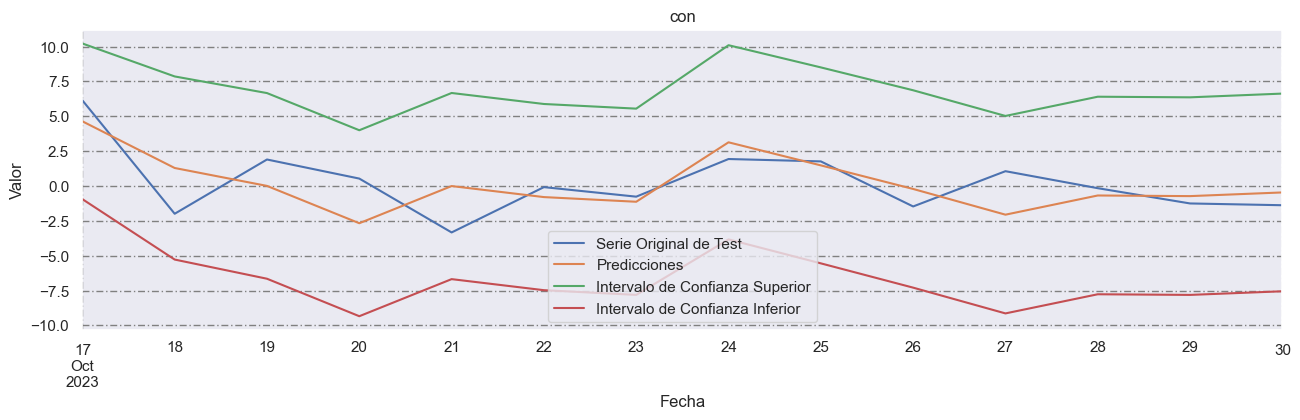

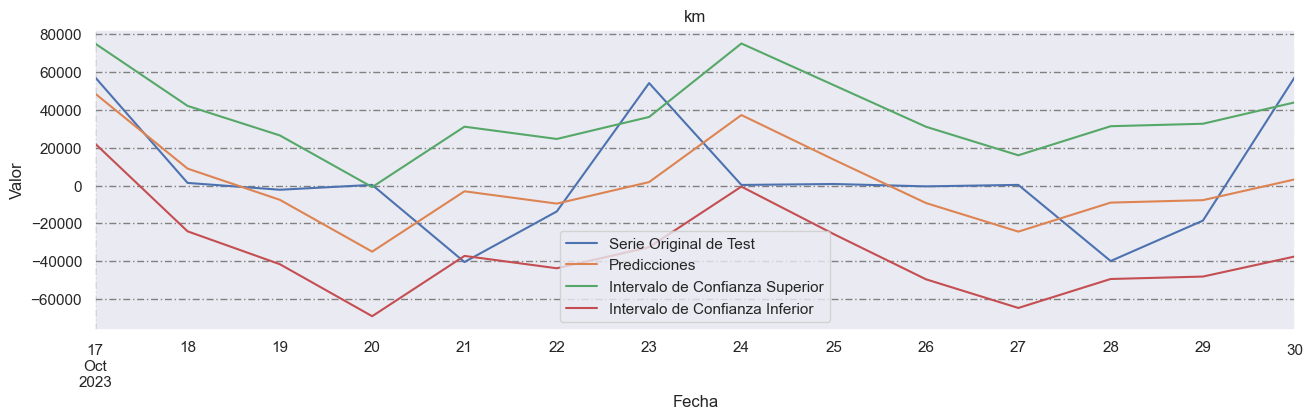

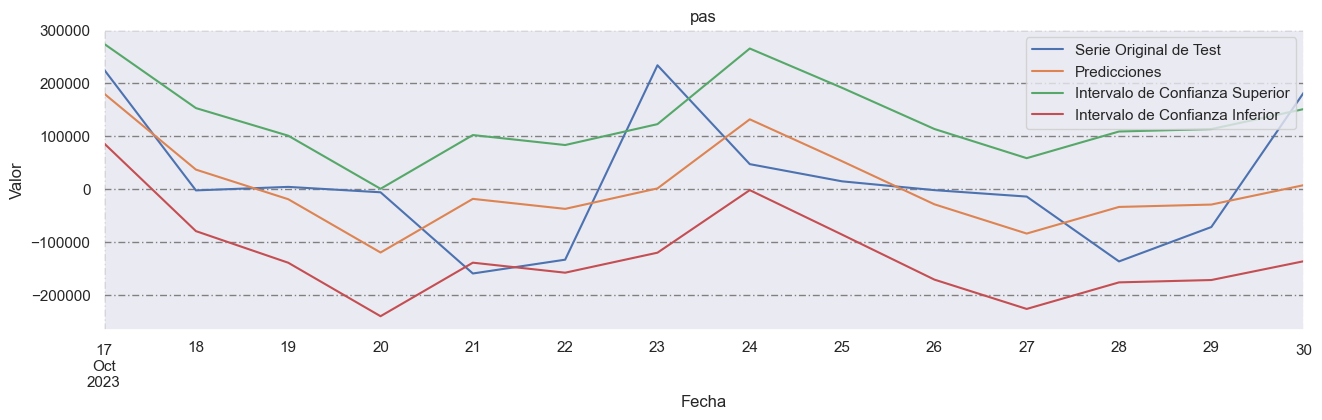

In [59]:
# Con la variable futuro se indican cuantas unidades en tiempo
# hacia adelante se quieren predecir
futuro = 14
lag_orden = 6

predicciones = model_fitted.forecast_interval(train.values[-lag_orden:], steps=futuro)

df = list()
for i in [1, 2, 3]:
    df.append(serializar(predicciones, test, i, futuro))

for i, serie in enumerate(serieVAR):
    graficar_pred(test[serie][:futuro], df[i], titulo=serie)

In [60]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [61]:
def test_residuos(residuos):


    # Test de Jarque Bera
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    jarquebera = jarque_bera(residuos)
    print('Jarque-Bera')
    print(f'p-valor: {jarquebera[1]}\n')

    # Test de Shapiro Wilks
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    shapir = shapiro(residuos)
    print('Shapiro')
    print(f'p-valor: {shapir[1]}\n')

In [62]:
def evaluar_residuos(residuos):
    residuos.plot(title='Residuos', figsize=(12, 3))
    plt.axhline(0, linestyle='--', color='k')
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].set_title('Residuos KDE')
    ax[1].set_title('Q-Q Plot')
    residuos.plot(kind='kde', ax=ax[0])
    probplot(residuos, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(residuos)
    acf.set_size_inches(12,3)
    plt.show()
    print('Descriptivo Residuos\n')
    print(f'{residuos.describe()}\n\n')
    print('Test sobre los Residuos\n')
    test_residuos(residuos)

MSE: 14898560886.272003
MAE: 88068.46276866845
RMSE: 122059.661175476
MAPE: 1.0
Evaluacion de residuos de Consumo 


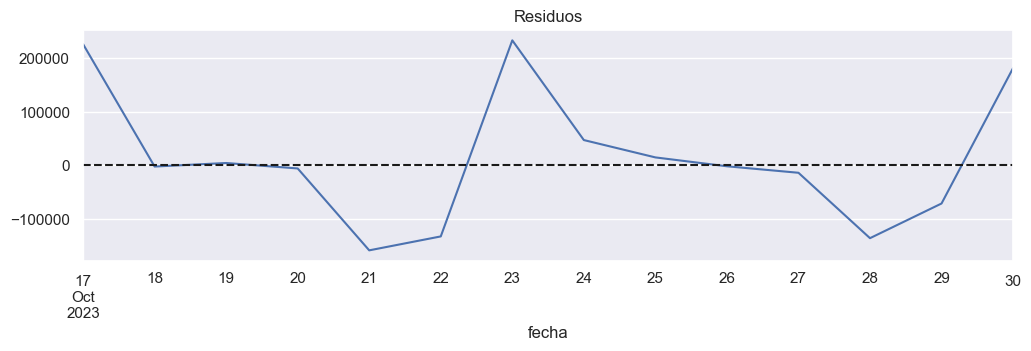

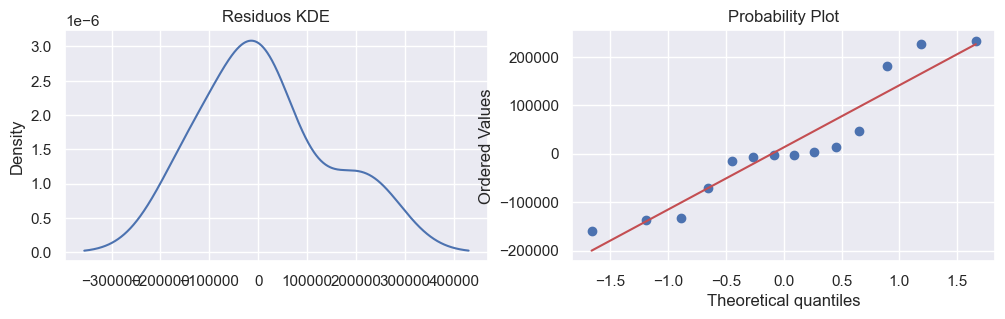

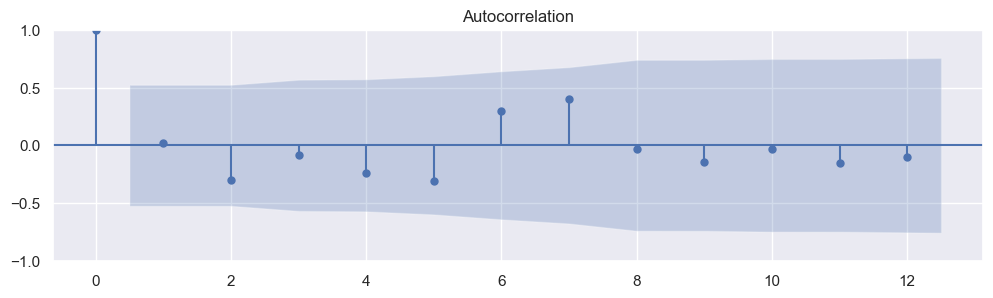

Descriptivo Residuos

count        14.000000
mean      13117.297509
std      125933.732114
min     -159219.997133
25%      -57175.942874
50%       -2146.541154
75%       39043.527893
max      233739.128935
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.6439545581353538

Shapiro
p-valor: 0.10046086460351944



In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey

evaluar_metricas(test[serie][:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Consumo ")
evaluar_residuos(test[serie][:futuro]-df[0].iloc[:,0])

MSE: 12763027679.196182
MAE: 81438.37225259302
RMSE: 112973.57071101268
MAPE: 1.6992
Evaluacion de residuos de Serie Km 


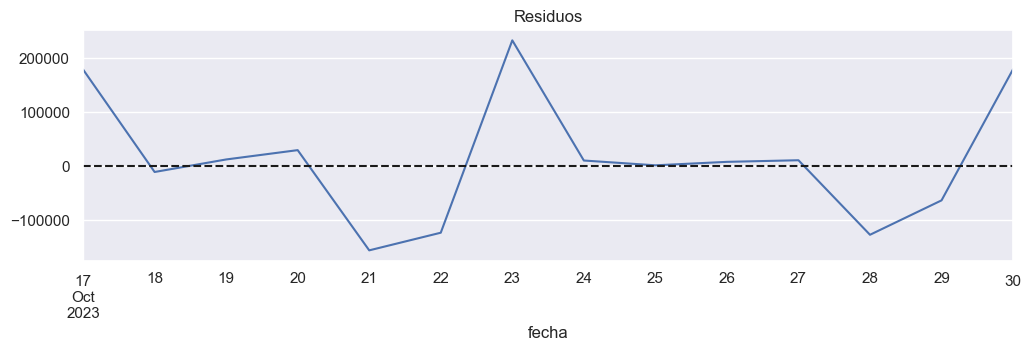

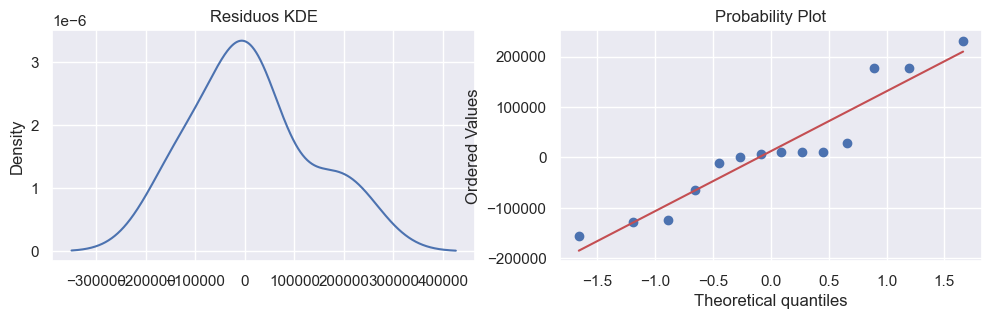

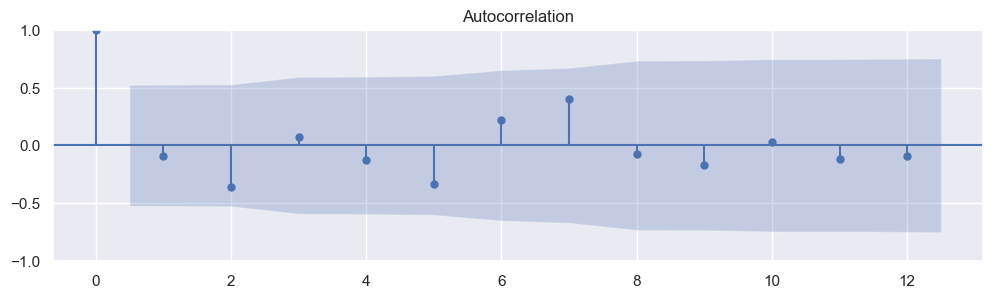

Descriptivo Residuos

count        14.000000
mean      12538.146775
std      116513.952867
min     -156170.830686
25%      -50696.041549
50%        8605.138787
75%       24725.375305
max      231915.398043
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.7084603355488122

Shapiro
p-valor: 0.13514578342437744



In [64]:
evaluar_metricas(test[serie][:futuro], df[1].iloc[:,0])
print(f"Evaluacion de residuos de Serie Km ")
evaluar_residuos(test[serie][:futuro]-df[1].iloc[:,0])

MSE: 11218969842.237118
MAE: 87823.35261192975
RMSE: 105919.63860511004
MAPE: 4.9612
Evaluacion de residuos de Serie Pasajeros 


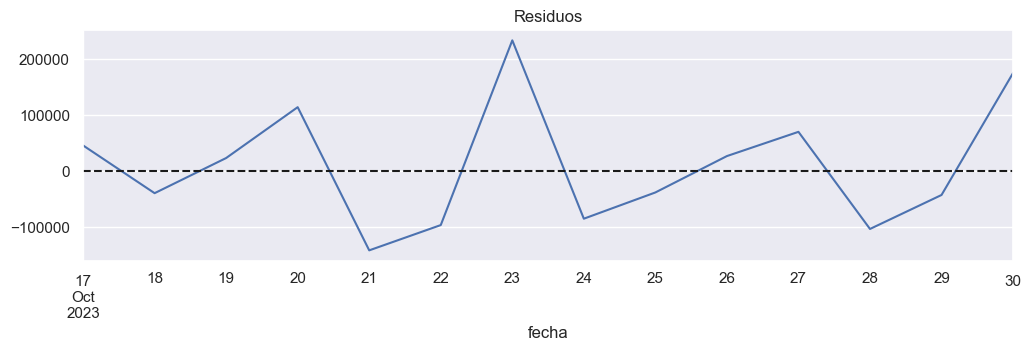

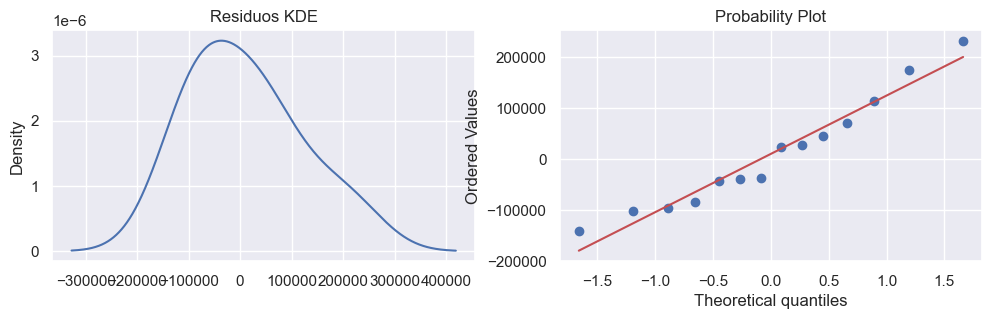

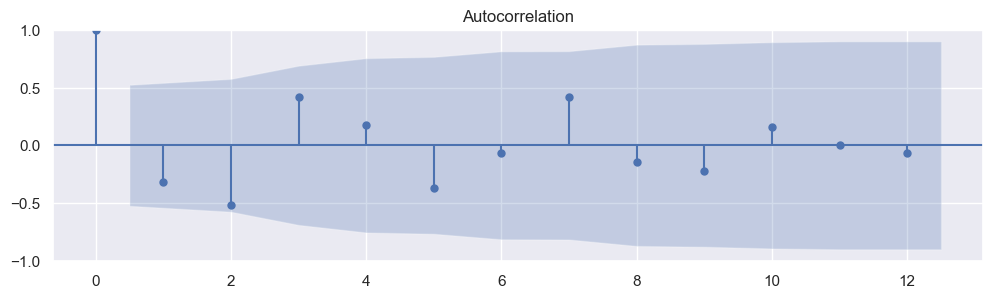

Descriptivo Residuos

count        14.000000
mean      10152.138267
std      109411.943882
min     -140829.451889
25%      -74033.812791
50%       -7339.692485
75%       63759.237847
max      232393.731015
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.6165440020140809

Shapiro
p-valor: 0.5591517686843872



In [65]:
evaluar_metricas(test[serie][:futuro], df[2].iloc[:,0])
print(f"Evaluacion de residuos de Serie Pasajeros ")
evaluar_residuos(test[serie][:futuro]-df[2].iloc[:,0])

## Residuos Incorrelacionados y con comportamiento Normal (no hay evidencia estadística para el rechazo)

Analizamos los Impulsos respuesta:

Cómo las variables en el modelo responden a un shock o perturbación en una de las variables.

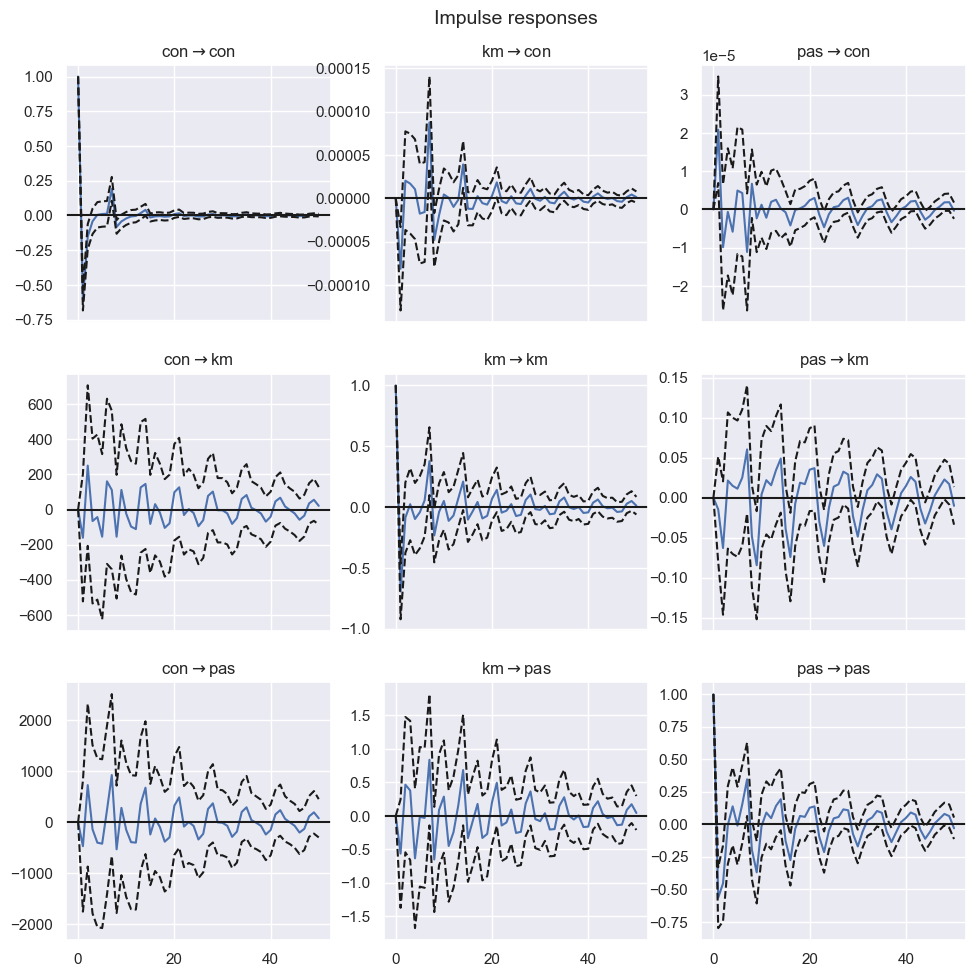

In [66]:
model_fitted.irf(50).plot();

# Clase V ejercicio 2

In [67]:
from statsmodels.tsa.stattools import coint

In [70]:
coint(consumo_d, km_d)

(-3.2750778835314374,
 0.05824366575955143,
 array([-3.91092758, -3.34419204, -3.0500426 ]))

In [72]:
coint(consumo_d, pasajeros_d)

(-3.1717776010471974,
 0.074775690947768,
 array([-3.91092758, -3.34419204, -3.0500426 ]))

In [73]:
coint(km_d, pasajeros_d)

(-5.346358580261907,
 3.6171947527504615e-05,
 array([-3.91092758, -3.34419204, -3.0500426 ]))

In [75]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(precios, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(precios,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(precios.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(serieVAR)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
con    ::  76.95     > 24.2761   =>   True
km     ::  22.9      > 12.3212   =>   True
pas    ::  0.07      > 4.1296    =>   False


Causalidad de Granger

El Test de Granger permite entender y analizar si los valores pasados de una variable x podrían ayudar a la predicción de los valores futuros de una variable y.

H0:"Serie x" NO CAUSA en el sentido de Granger a "serie y" (p-value > 0.05 No Rechazo H0)

H1:"Serie x" CAUSA en el sentido de Granger a "serie y"

A continuación, se analiza las relaciones de los precios de los hidrocarburos.

In [110]:
print('km causes con?\n')
print('------------------')
granger_1 = grangercausalitytests(serieVAR[['con', 'km']], 3)

print('------------------')
print('------------------')

print('\con causes km?\n')
print('------------------')
granger_2 = grangercausalitytests(serieVAR[['km', 'con']], 3)

km causes con?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7073  , p=0.1003  , df_denom=756, df_num=1
ssr based chi2 test:   chi2=2.7180  , p=0.0992  , df=1
likelihood ratio test: chi2=2.7132  , p=0.0995  , df=1
parameter F test:         F=2.7073  , p=0.1003  , df_denom=756, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=19.7879 , p=0.0000  , df_denom=753, df_num=2
ssr based chi2 test:   chi2=39.8385 , p=0.0000  , df=2
likelihood ratio test: chi2=38.8269 , p=0.0000  , df=2
parameter F test:         F=19.7879 , p=0.0000  , df_denom=753, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.0659 , p=0.0000  , df_denom=750, df_num=3
ssr based chi2 test:   chi2=42.5917 , p=0.0000  , df=3
likelihood ratio test: chi2=41.4366 , p=0.0000  , df=3
parameter F test:         F=14.0659 , p=0.0000  , df_denom=750, df_num=3
------------------
------------------
\con causes km?

----

In [79]:
print('pas causes con?\n')
print('------------------')
granger_1 = grangercausalitytests(serieVAR[['con', 'pas']], 3)

print('\con causes pas?\n')
print('------------------')
granger_2 = grangercausalitytests(serieVAR[['pas', 'con']], 3)


pas causes con?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4527  , p=0.0635  , df_denom=756, df_num=1
ssr based chi2 test:   chi2=3.4664  , p=0.0626  , df=1
likelihood ratio test: chi2=3.4585  , p=0.0629  , df=1
parameter F test:         F=3.4527  , p=0.0635  , df_denom=756, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=23.0733 , p=0.0000  , df_denom=753, df_num=2
ssr based chi2 test:   chi2=46.4529 , p=0.0000  , df=2
likelihood ratio test: chi2=45.0851 , p=0.0000  , df=2
parameter F test:         F=23.0733 , p=0.0000  , df_denom=753, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=16.5271 , p=0.0000  , df_denom=750, df_num=3
ssr based chi2 test:   chi2=50.0441 , p=0.0000  , df=3
likelihood ratio test: chi2=48.4594 , p=0.0000  , df=3
parameter F test:         F=16.5271 , p=0.0000  , df_denom=750, df_num=3
\con causes pas?

------------------

Granger Causality
nu

Modelo VAR

In [80]:
train_df=serieVAR[:-14]
test_df=serieVAR[-14:]

In [81]:
model = VAR(train_df.diff()[1:])

In [82]:
sorted_order=model.select_order(maxlags=10)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        42.02       42.04   1.769e+18       42.02
1        41.79       41.86   1.408e+18       41.82
2        41.55       41.68   1.112e+18       41.60
3        41.43       41.62   9.822e+17       41.50
4        41.32       41.56   8.782e+17       41.41
5        40.91       41.21   5.828e+17       41.02
6       40.24*      40.59*  2.986e+17*      40.38*
7        40.24       40.65   2.997e+17       40.40
8        40.24       40.71   2.997e+17       40.42
9        40.25       40.77   3.013e+17       40.45
10       40.25       40.84   3.036e+17       40.48
--------------------------------------------------


In [84]:
results = model.fit(maxlags=6,
                    ic='aic',
                    verbose=1
                   )

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 6, BIC -> 6, FPE -> 6, HQIC ->  6>
Using 6 based on aic criterion


In [85]:
print(results.summary()._resid_info())

Correlation matrix of residuals
            con        km       pas
con    1.000000  0.344805  0.380855
km     0.344805  1.000000  0.950930
pas    0.380855  0.950930  1.000000




Errores correlacionados. En este caso, parece haber correlaciones positivas significativas entre los residuos de las tres variables, lo que sugiere que podría haber relaciones de corto plazo entre estas variables en el modelo VAR.

In [86]:
normality = results.test_normality()
print(normality.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2745.          12.59   0.000  6
----------------------------------------


Podemos rechazar normalidad en los residuos

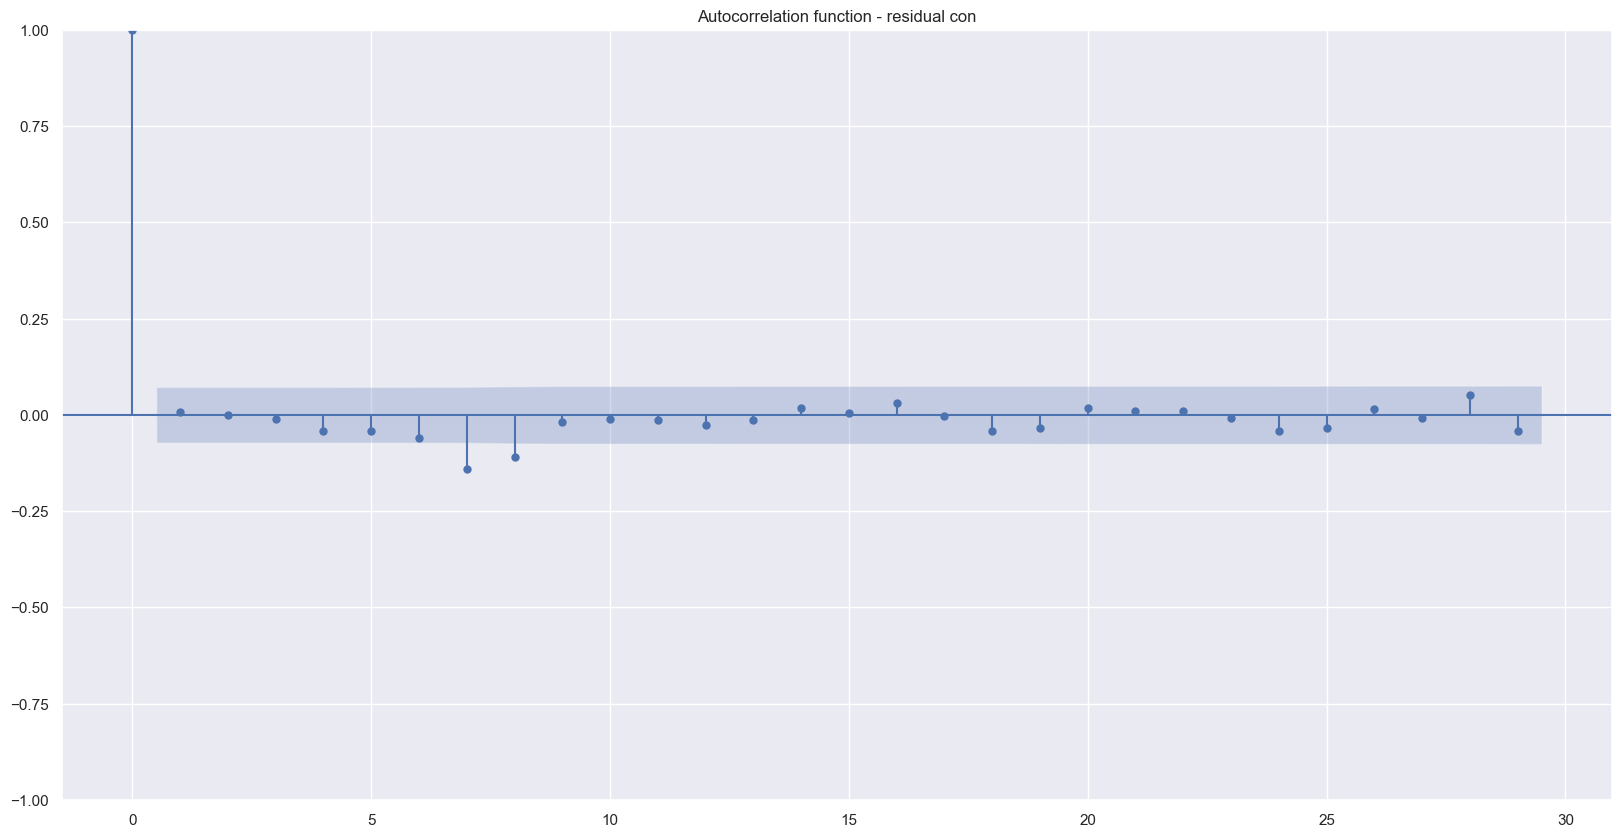

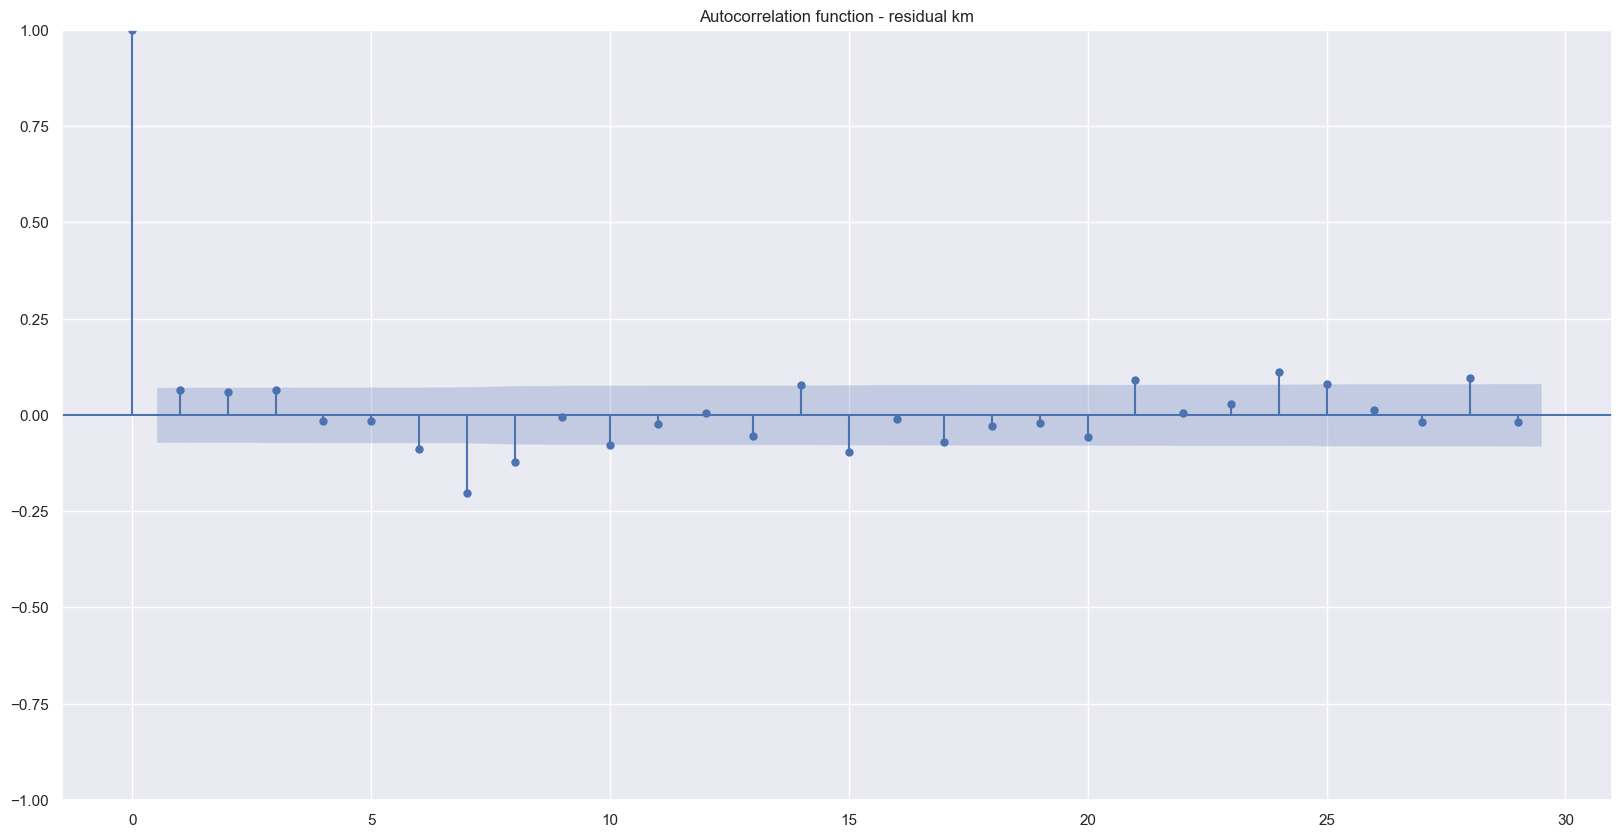

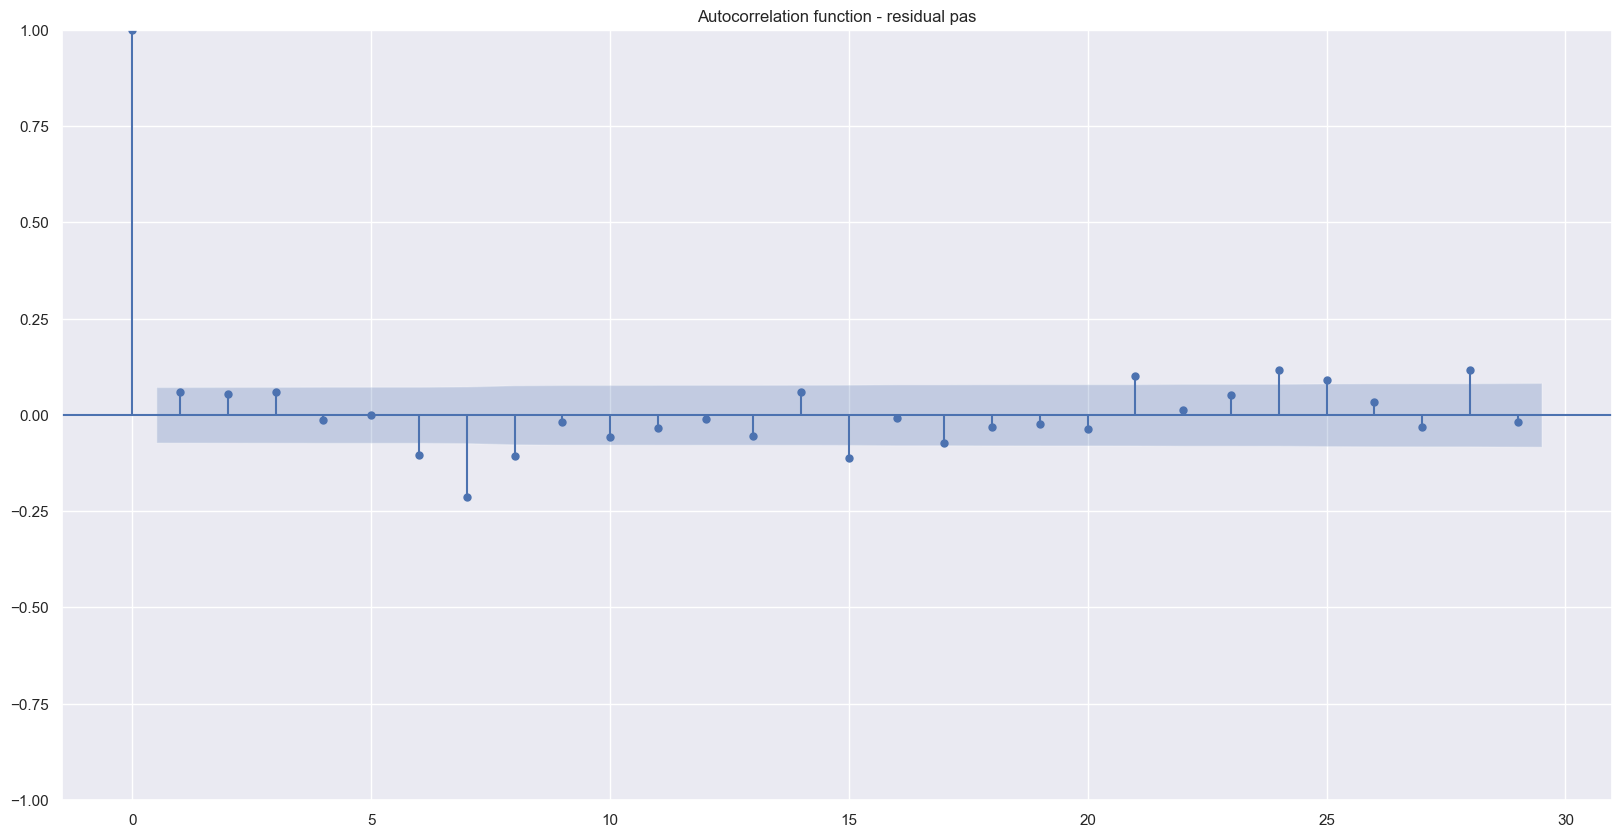

In [88]:
for quant in serieVAR.columns:
    plot_acf(results.resid[quant],title='Autocorrelation function - residual {}'.format(quant))

Los gráficos de los residuos muestran que no hay autocorrelaciones en cada residuo, como sería de esperar si el modelo utilizado se ajustara bien a los datos.

Impuso Respuesta

Para comprender mejor cómo el cambio de una cantidad en el pasado influye en otra cantidad en el presente, podemos utilizar la respuesta impulsiva. La idea es que comencemos con un cambio de unidad para una sola cantidad en n rezagos y estudiar cómo se propaga este shock en otra variable.

Consideraremos la función impulso-respuesta para aquellas variables que están relacionadas causalmente con Granger.

A través de la relación impulso - respuesta, calculando el efecto sobre Estireno a partir de un impulso unitario en Petroleo, se observa:

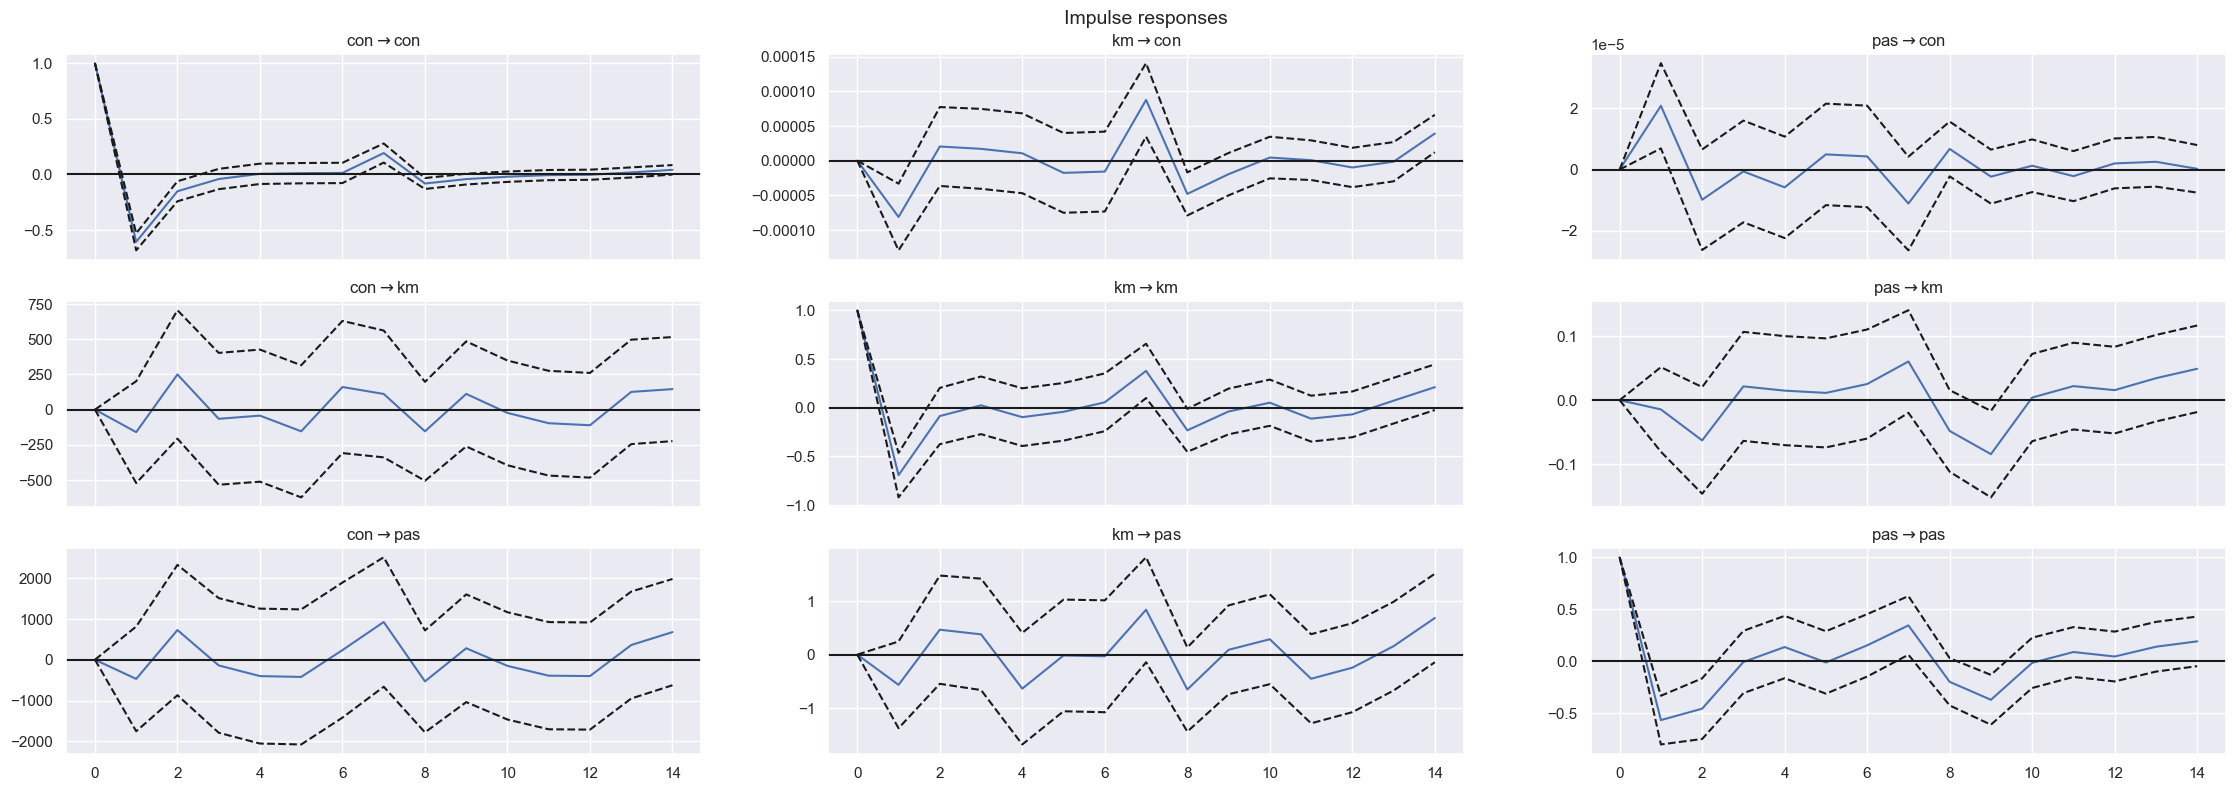

In [90]:
# Impulse response function for the model we trained
irf = results.irf(periods=14)
irf.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

In [92]:
fevd = results.fevd(14)

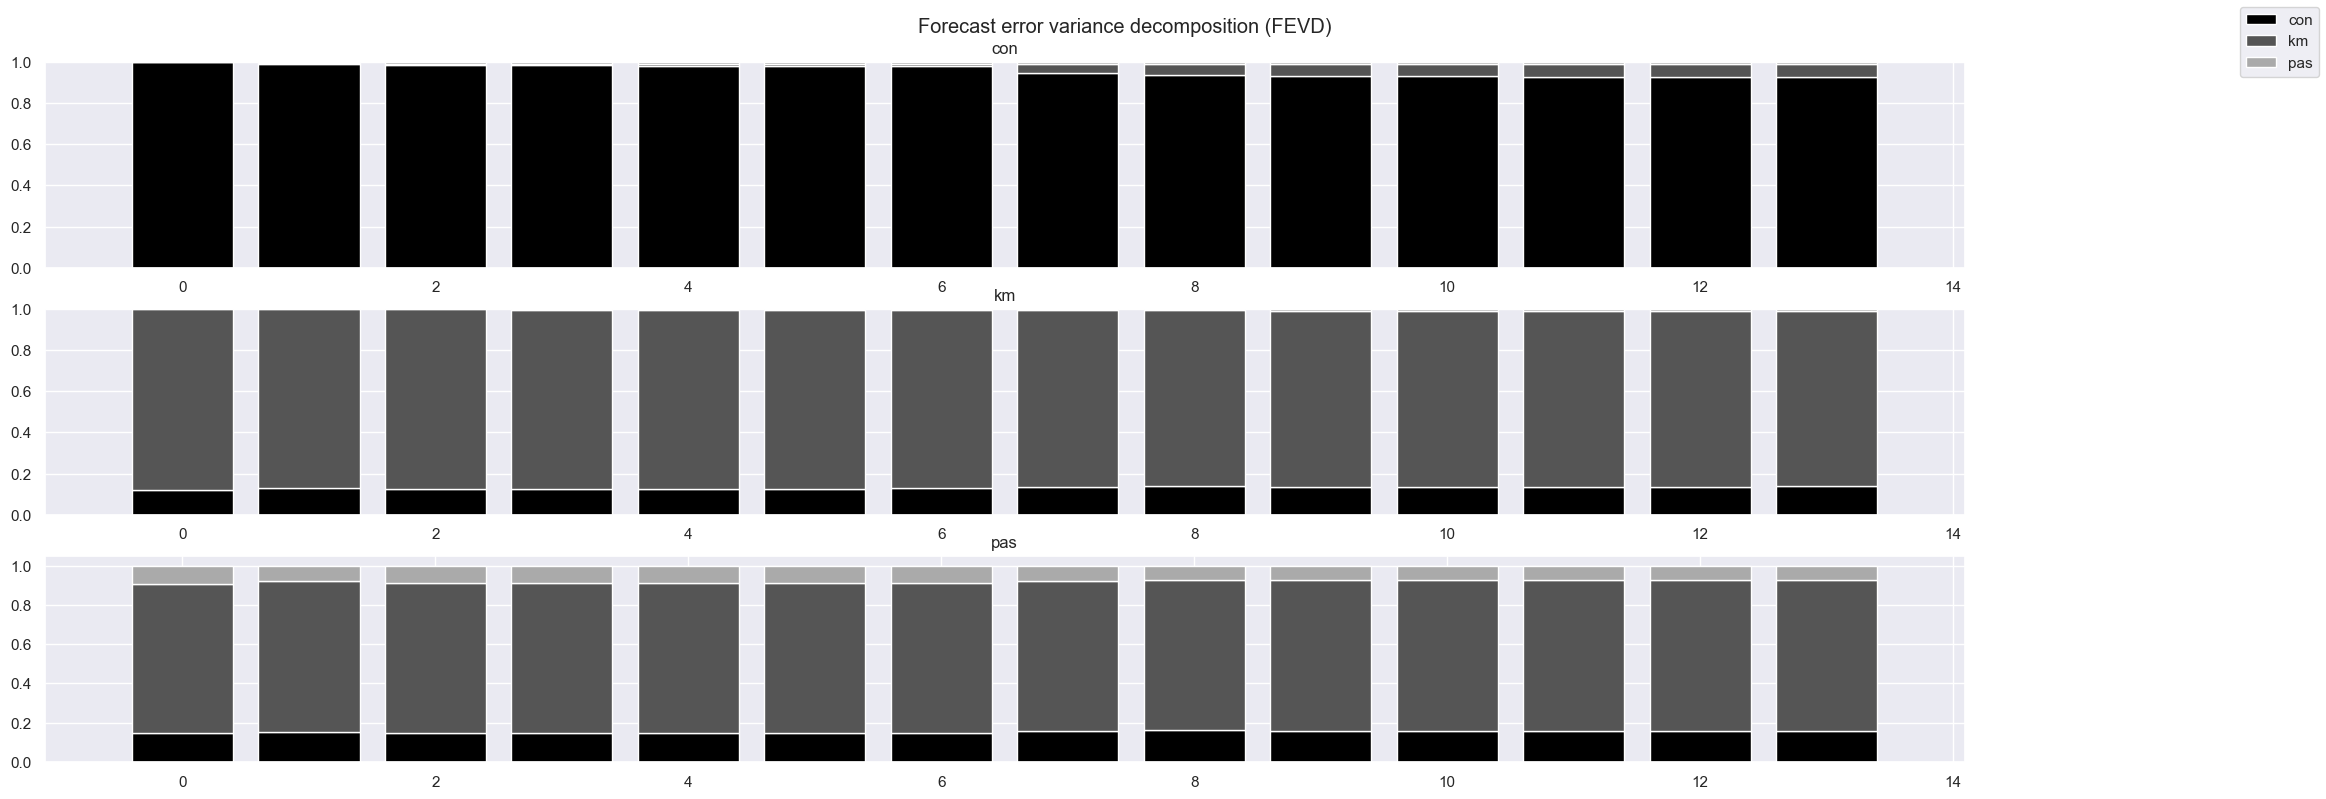

In [93]:
fevd.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

In [94]:
fevd.summary()

FEVD for con
           con        km       pas
0     1.000000  0.000000  0.000000
1     0.989448  0.002361  0.008191
2     0.985908  0.004338  0.009754
3     0.982843  0.007429  0.009728
4     0.981231  0.008442  0.010327
5     0.980767  0.008464  0.010769
6     0.980400  0.008500  0.011100
7     0.946533  0.041188  0.012278
8     0.938319  0.048877  0.012803
9     0.929980  0.057312  0.012708
10    0.929120  0.058159  0.012721
11    0.928590  0.058624  0.012786
12    0.928407  0.058745  0.012848
13    0.927828  0.059236  0.012936

FEVD for km
           con        km       pas
0     0.118890  0.881110  0.000000
1     0.130224  0.869621  0.000155
2     0.125897  0.871186  0.002917
3     0.125548  0.871226  0.003226
4     0.125642  0.870983  0.003375
5     0.126172  0.870367  0.003462
6     0.128748  0.867405  0.003847
7     0.133591  0.861152  0.005258
8     0.137655  0.856278  0.006067
9     0.135911  0.854750  0.009340
10    0.135820  0.854848  0.009332
11    0.136033  0.854406  0.0

Interpretacion: Observando por ejemplo el período 5, Dado un impulso en la variable Estireno, el 54% esta explicado por ella misma, el 18% Por el Benceno y un 27% Por el petróleo.

Forecast

In [95]:
# Get the lag order
lag_order = results.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train_df.values[-lag_order:]
forecast_input

6


array([[4.51096263e+01, 1.01517207e+05, 2.84205000e+05],
       [4.71328780e+01, 1.00921656e+05, 3.19953000e+05],
       [4.58126907e+01, 4.45504630e+04, 1.23015000e+05],
       [4.50788608e+01, 6.07578290e+04, 1.42922000e+05],
       [4.36592972e+01, 4.52259200e+04, 8.15880000e+04],
       [4.08607546e+01, 4.48178610e+04, 7.54180000e+04]])

In [97]:
# Forecast
n_forecast = 14
fc = results.forecast(y=forecast_input, steps=n_forecast)
df_forecast = pd.DataFrame(fc, index=serieVAR.index[-n_forecast:], columns=serieVAR.columns + '_1d')
df_forecast

con_1d          km_1d         pas_1d
fecha                                               
2023-10-17 -129.410232 -296772.788540 -907359.027753
2023-10-18  -14.269317   27727.721208   88354.029303
2023-10-19   15.960335   83426.898987  289448.967082
2023-10-20   14.831703   25793.020754   53578.833152
2023-10-21   16.759753   51309.477149  192900.676612
2023-10-22   15.356351   72443.813883  247578.154324
2023-10-23   13.251238   -4404.259955   40698.769945
2023-10-24  -38.356582 -203915.918321 -717868.096018
2023-10-25  -11.441696  -16082.871572  -89290.040957
2023-10-26    6.230496   68774.948932  227491.684734
2023-10-27    4.798704   24217.276426   74727.525751
2023-10-28    7.637221   50861.651104  180782.128428
2023-10-29    9.154235   71561.458057  262817.814021
2023-10-30    3.456833  -14827.995002  -17687.871991

Invertimos las transformaciones: queremos revertir las transformaciones que se han aplicado previamente a un conjunto de datos con el fin de obtener pronósticos

In [98]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = train_df.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train_df[col].iloc[-1]-train_df[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train_df[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [100]:
df_results = invert_transformation(train_df, df_forecast, second_diff=False)
df_results.loc[:, ['con_forecast', 'km_forecast', 'pas_forecast']]

con_forecast    km_forecast   pas_forecast
fecha                                                 
2023-10-17    -88.549478 -251954.927540 -831941.027753
2023-10-18   -102.818795 -224227.206332 -743586.998450
2023-10-19    -86.858460 -140800.307346 -454138.031368
2023-10-20    -72.026758 -115007.286592 -400559.198215
2023-10-21    -55.267005  -63697.809442 -207658.521603
2023-10-22    -39.910654    8746.004440   39919.632721
2023-10-23    -26.659415    4341.744485   80618.402666
2023-10-24    -65.015998 -199574.173836 -637249.693351
2023-10-25    -76.457694 -215657.045408 -726539.734309
2023-10-26    -70.227198 -146882.096475 -499048.049575
2023-10-27    -65.428493 -122664.820049 -424320.523824
2023-10-28    -57.791272  -71803.168945 -243538.395396
2023-10-29    -48.637037    -241.710888   19279.418625
2023-10-30    -45.180205  -15069.705890    1591.546634

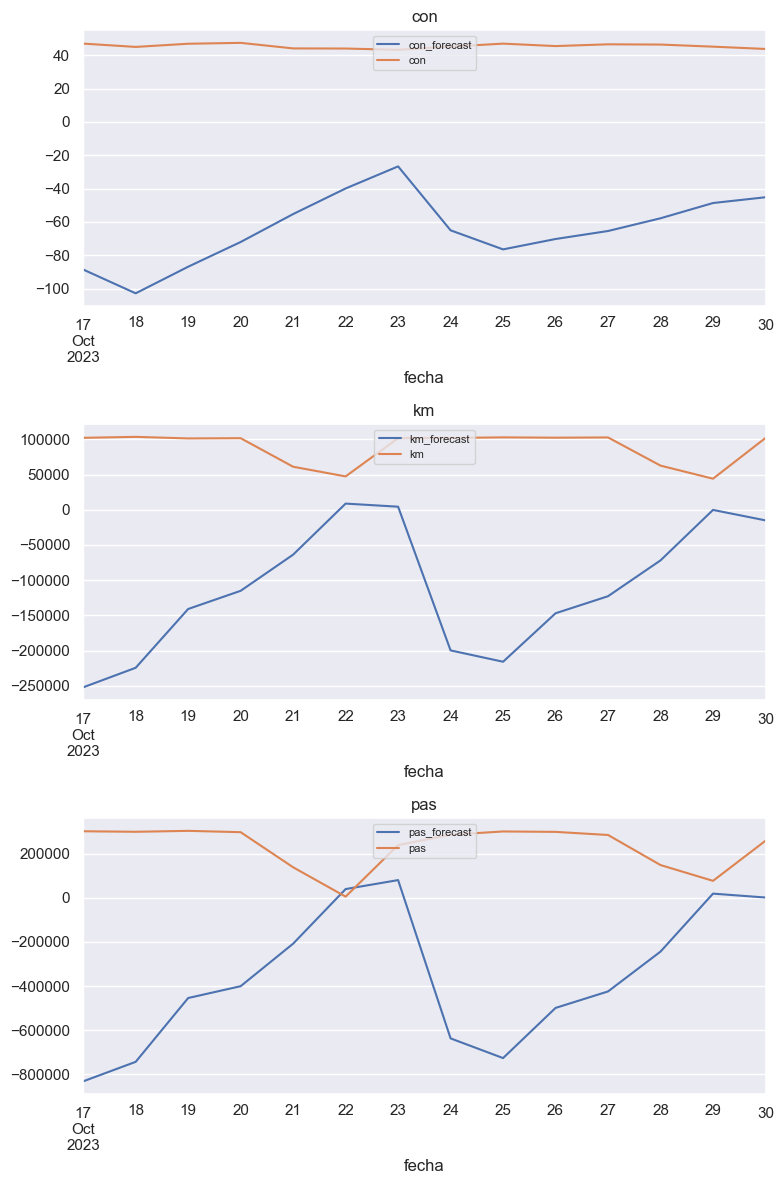

In [102]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8, 12))

for i, (col,ax) in enumerate(zip(serieVAR.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col][-n_forecast:].plot(legend=True, ax=ax);
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    #ax.tick_params(labelsize=6, direction= 'out')
    ax.legend(fontsize="8",loc='upper center')

plt.tight_layout()
plt.show();

Evaluate the Forecasts

In [107]:
import math
from statistics import mean
rmse_estireno=math.sqrt(mean_squared_error(df_results['con_forecast'],test_df['con']))
print('Mean value of Consumo is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['con']),rmse_estireno))

rmse_benceno=math.sqrt(mean_squared_error(df_results['km_forecast'],test_df['km']))
print('Mean value of Kilómetros is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['km']),rmse_benceno))

rmse_petroleo=math.sqrt(mean_squared_error(df_results['pas_forecast'],test_df['pas']))
print('Mean value of Pasajeros is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['pas']),rmse_petroleo))

Mean value of Consumo is : 45.53957219190988. Root Mean Squared Error is :111.84653912878436
Mean value of Km is : 88294.45671428571. Root Mean Squared Error is :224146.1475109136
Mean value of Pasajeros is : 231754.85714285713. Root Mean Squared Error is :699859.2867897172


#######################

# Pregunta 10

Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.

In [8]:
# Dataframe de las tres series que se utilizarán para el modelo VAR
serieVAR=pd.concat([pas_diff_4, km_diff_4, con_diff_4], axis=1)

In [9]:
# Separacion Train/Test
# Seleccion de train
train = serieVAR[:-14]

# Seleccionamos de test
test = serieVAR[-14:]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train,"\n\n", test)

                 pas         km       con
fecha                                    
2021-10-05    6540.0    545.445  0.945639
2021-10-06  100021.0  24165.307  1.709404
2021-10-07   75013.0  15437.506  6.814571
2021-10-08  -95899.0 -38171.089 -1.813478
2021-10-09  -90643.0 -25337.853 -5.776567
...              ...        ...       ...
2023-10-12  230014.0  55632.198  6.877994
2023-10-13 -175508.0 -57590.980 -3.142773
2023-10-14 -156565.0 -41135.133 -1.573782
2023-10-15 -202617.0 -56291.287 -1.450329
2023-10-16 -244535.0 -56103.795 -6.272123

[742 rows x 3 columns] 

                  pas         km       con
fecha                                    
2023-10-17  179071.0  57498.272  1.194718
2023-10-18  156776.0  42680.509 -0.060832
2023-10-19  222331.0  55979.390  3.261288
2023-10-20  222533.0  56728.877  6.593475
2023-10-21 -163355.0 -41006.376 -2.883154
2023-10-22 -294116.0 -56116.457 -0.973448
2023-10-23  -64599.0    367.246 -3.639392
2023-10-24  -11471.0    337.499 -2.235867
2023-10

In [10]:
model = VAR(train)
x = model.select_order(maxlags=70)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [11]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Dec, 2023
Time:                     00:07:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    41.4534
Nobs:                     730.000    HQIC:                   41.0245
Log likelihood:          -17872.1    FPE:                5.00964e+17
AIC:                      40.7551    Det(Omega_mle):     4.31906e+17
--------------------------------------------------------------------
Results for equation pas
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const         919.163373      1855.342327            0.495           0.620
L1.pas          0.335469         0.116477            2.880           0.004
L1.km          -0.278539         0.405676           -0.687           0.492
L1.con     

Predicción

In [12]:
# Funcion que recibe listas con las predicciones e intervalos de confianza de las 3 series y devuelve un
# dataframe para la serie indicada por la variable indice
def serializar(predicciones_, test_, indice, futuro_, intervalos=True):

    serie = {
        "FECHA": test_.index[:futuro_],
        "serie"+str(indice): predicciones_[0][:,indice-1].tolist(),
        "serie"+str(indice)+"_inf": predicciones_[1][:,indice-1].tolist(),
        "serie"+str(indice)+"_sup": predicciones_[2][:,indice-1].tolist()}
    serie = pd.DataFrame(serie, columns=["FECHA", "serie"+str(indice),
                                         "serie"+str(indice)+"_inf", "serie"+str(indice)+"_sup"])
    serie.set_index("FECHA", inplace=True)
    if (intervalos==False):
        serie.loc[serie["serie"+str(indice)+"_inf"] < 0, "serie"+str(indice)+"_inf"] = 0
        serie.loc[serie["serie"+str(indice)+"_sup"] < 0, "serie"+str(indice)+"_sup"] = 0
    return serie

In [13]:
def graficar_pred(serie_test, serie_pred, titulo="Valores Originales vs Predicciones",
                  xlabel="Fecha", ylabel="Valor", intervalos=True):
    # serie_test:
    # serie_pred:

    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.iloc[:,0].plot(label="Predicciones")
    if (intervalos==True):
        serie_pred.iloc[:,2].plot(label="Intervalo de Confianza Superior")
        serie_pred.iloc[:,1].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.5', dashes=(5,2,1,2))

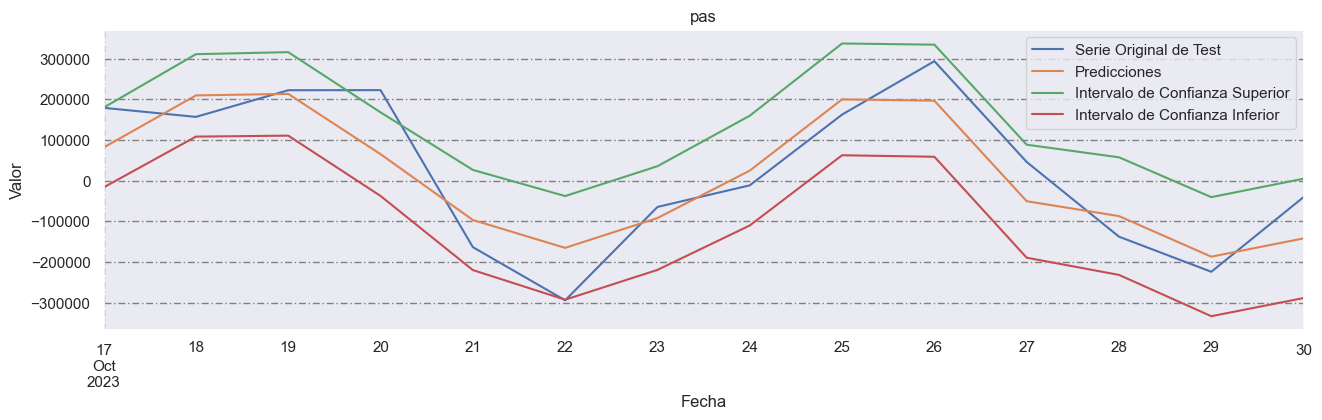

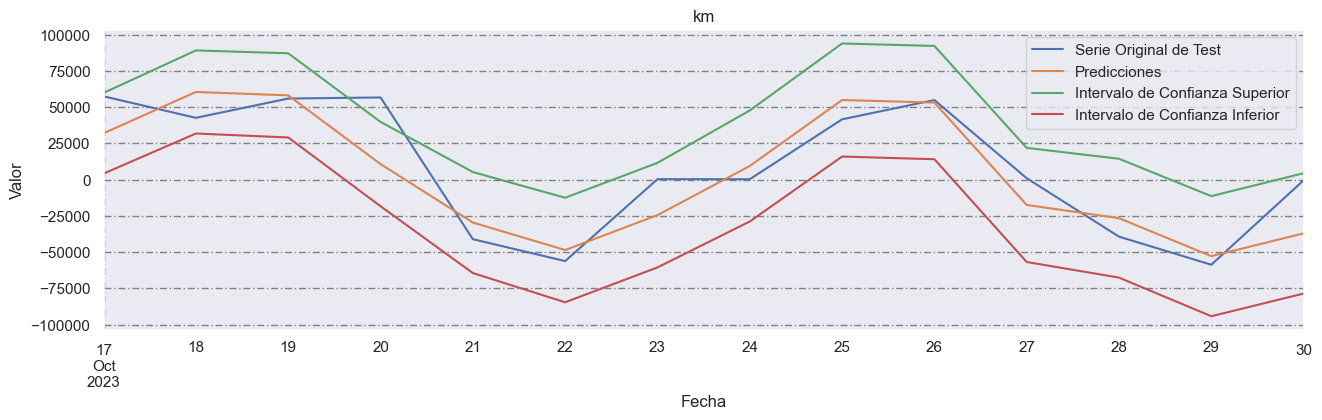

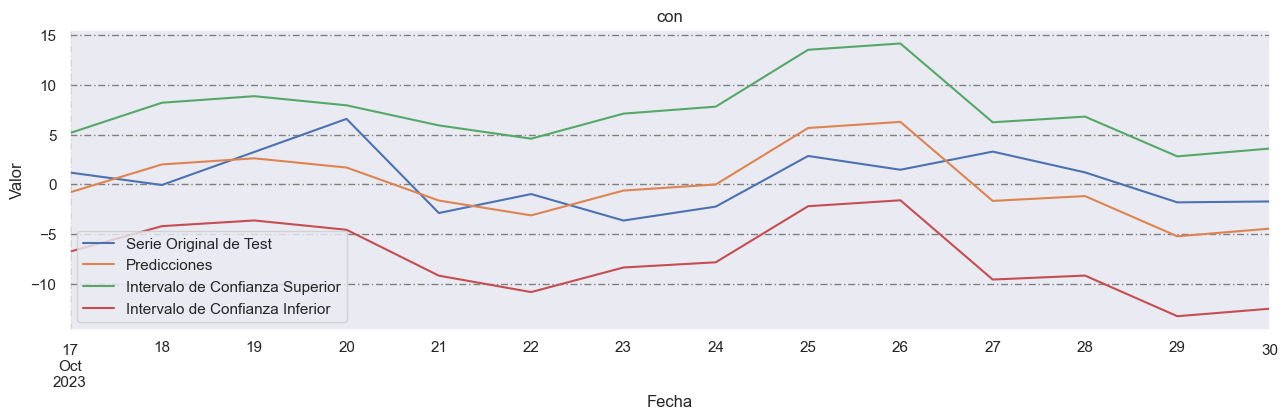

In [14]:
# Con la variable futuro se indican cuantas unidades en tiempo
# hacia adelante se quieren predecir
futuro = 14
lag_orden = 12

predicciones = model_fitted.forecast_interval(train.values[-lag_orden:], steps=futuro)

df = list()
for i in [1, 2, 3]:
    df.append(serializar(predicciones, test, i, futuro))

for i, serie in enumerate(serieVAR):
    graficar_pred(test[serie][:futuro], df[i], titulo=serie)

In [15]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [16]:
def test_residuos(residuos):


    # Test de Jarque Bera
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    jarquebera = jarque_bera(residuos)
    print('Jarque-Bera')
    print(f'p-valor: {jarquebera[1]}\n')

    # Test de Shapiro Wilks
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    shapir = shapiro(residuos)
    print('Shapiro')
    print(f'p-valor: {shapir[1]}\n')

In [17]:
def evaluar_residuos(residuos):
    residuos.plot(title='Residuos', figsize=(12, 3))
    plt.axhline(0, linestyle='--', color='k')
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].set_title('Residuos KDE')
    ax[1].set_title('Q-Q Plot')
    residuos.plot(kind='kde', ax=ax[0])
    probplot(residuos, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(residuos)
    acf.set_size_inches(12,3)
    plt.show()
    print('Descriptivo Residuos\n')
    print(f'{residuos.describe()}\n\n')
    print('Test sobre los Residuos\n')
    test_residuos(residuos)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey

MSE: 20693482138.038933
MAE: 129330.4126797623
RMSE: 143852.2927799169
MAPE: 307509.3776
Evaluacion de residuos de Serie Pasajeros 


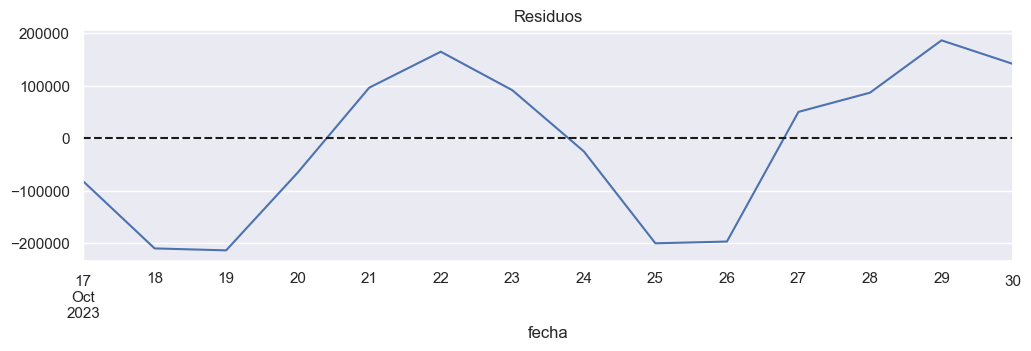

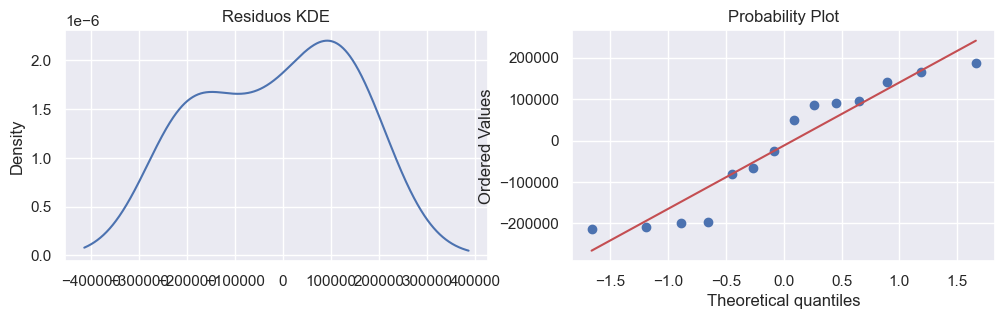

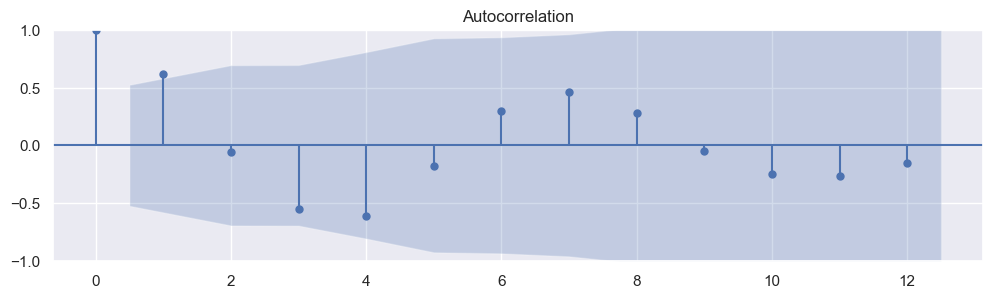

Descriptivo Residuos

count        14.000000
mean     -12197.633485
std      148744.954215
min     -213292.200751
25%     -167762.833859
50%       12864.681516
75%       95451.106141
max      186819.615041
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.5093807299769759

Shapiro
p-valor: 0.07848353683948517



In [19]:
evaluar_metricas(test[serie][:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie Pasajeros ")
evaluar_residuos(test[serie][:futuro]-df[0].iloc[:,0])

MSE: 1650044539.6455562
MAE: 36801.04277754612
RMSE: 40620.740264617976
MAPE: 88946.8502
Evaluacion de residuos de Serie Km 


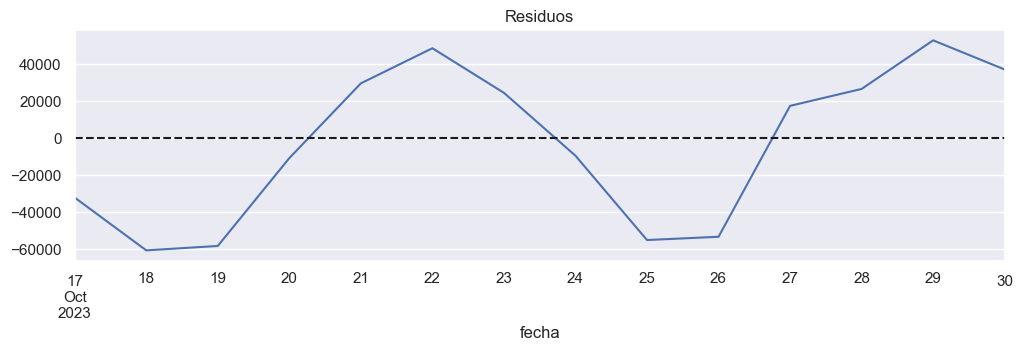

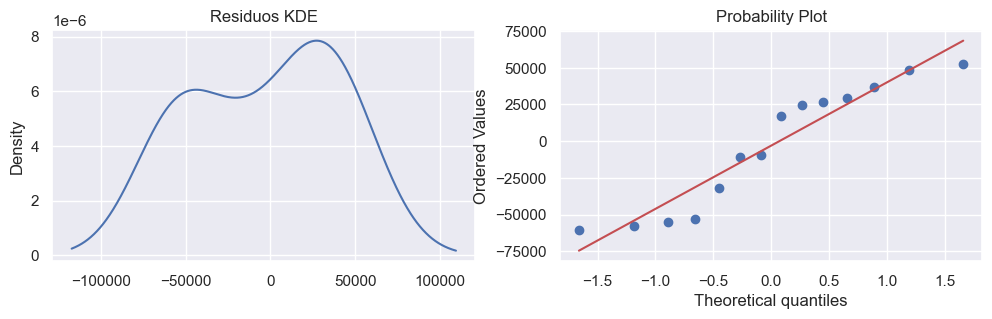

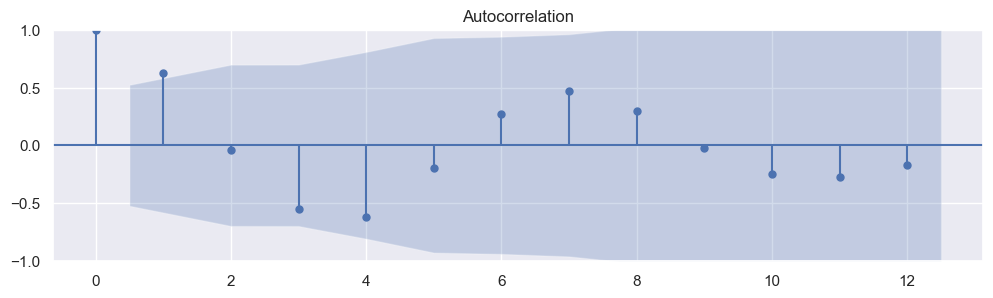

Descriptivo Residuos

count       14.000000
mean     -3073.743218
std      42033.277103
min     -60514.677482
25%     -47907.739523
50%       3960.692546
75%      28780.269138
max      52723.992130
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.49393105610436294

Shapiro
p-valor: 0.07640235126018524



In [20]:
evaluar_metricas(test[serie][:futuro], df[1].iloc[:,0])
print(f"Evaluacion de residuos de Serie Km ")
evaluar_residuos(test[serie][:futuro]-df[1].iloc[:,0])

MSE: 9.54152606405005
MAE: 2.813822180389768
RMSE: 3.088936073156913
MAPE: 3.7364
Evaluacion de residuos de Serie Consumo 


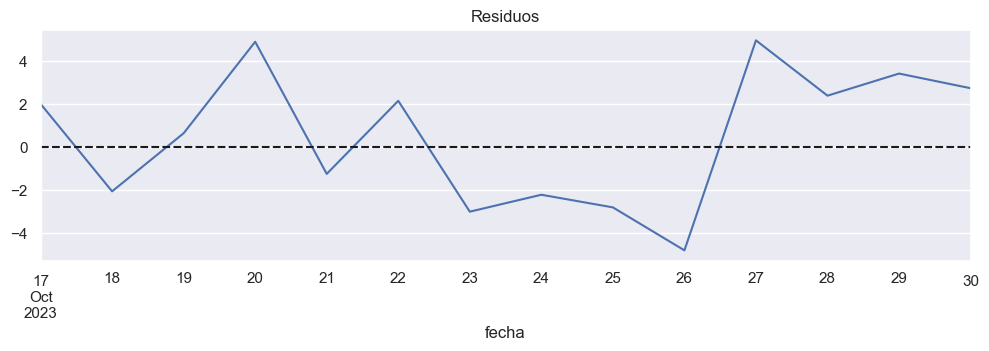

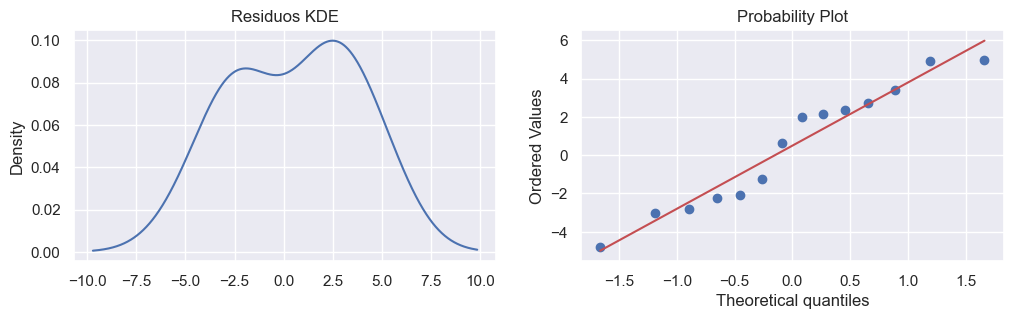

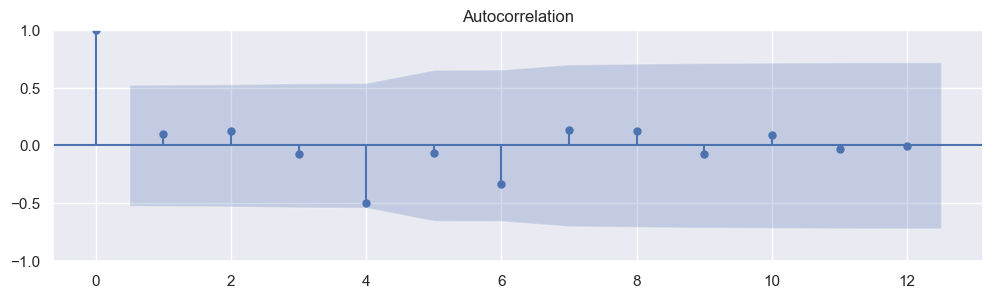

Descriptivo Residuos

count    14.000000
mean      0.498853
std       3.163462
min      -4.817747
25%      -2.188091
50%       1.321068
75%       2.647295
max       4.963800
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.6081378163146407

Shapiro
p-valor: 0.34636783599853516



In [21]:
evaluar_metricas(test[serie][:futuro], df[2].iloc[:,0])
print(f"Evaluacion de residuos de Serie Consumo ")
evaluar_residuos(test[serie][:futuro]-df[2].iloc[:,0])

Residuos Incorrelacionados y con comportamiento Normal (no hay evidencia estadística para el rechazo)


# Pregunta 11

Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad. Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis.

Cómo las variables en el modelo responden a un shock o perturbación en una de las variables

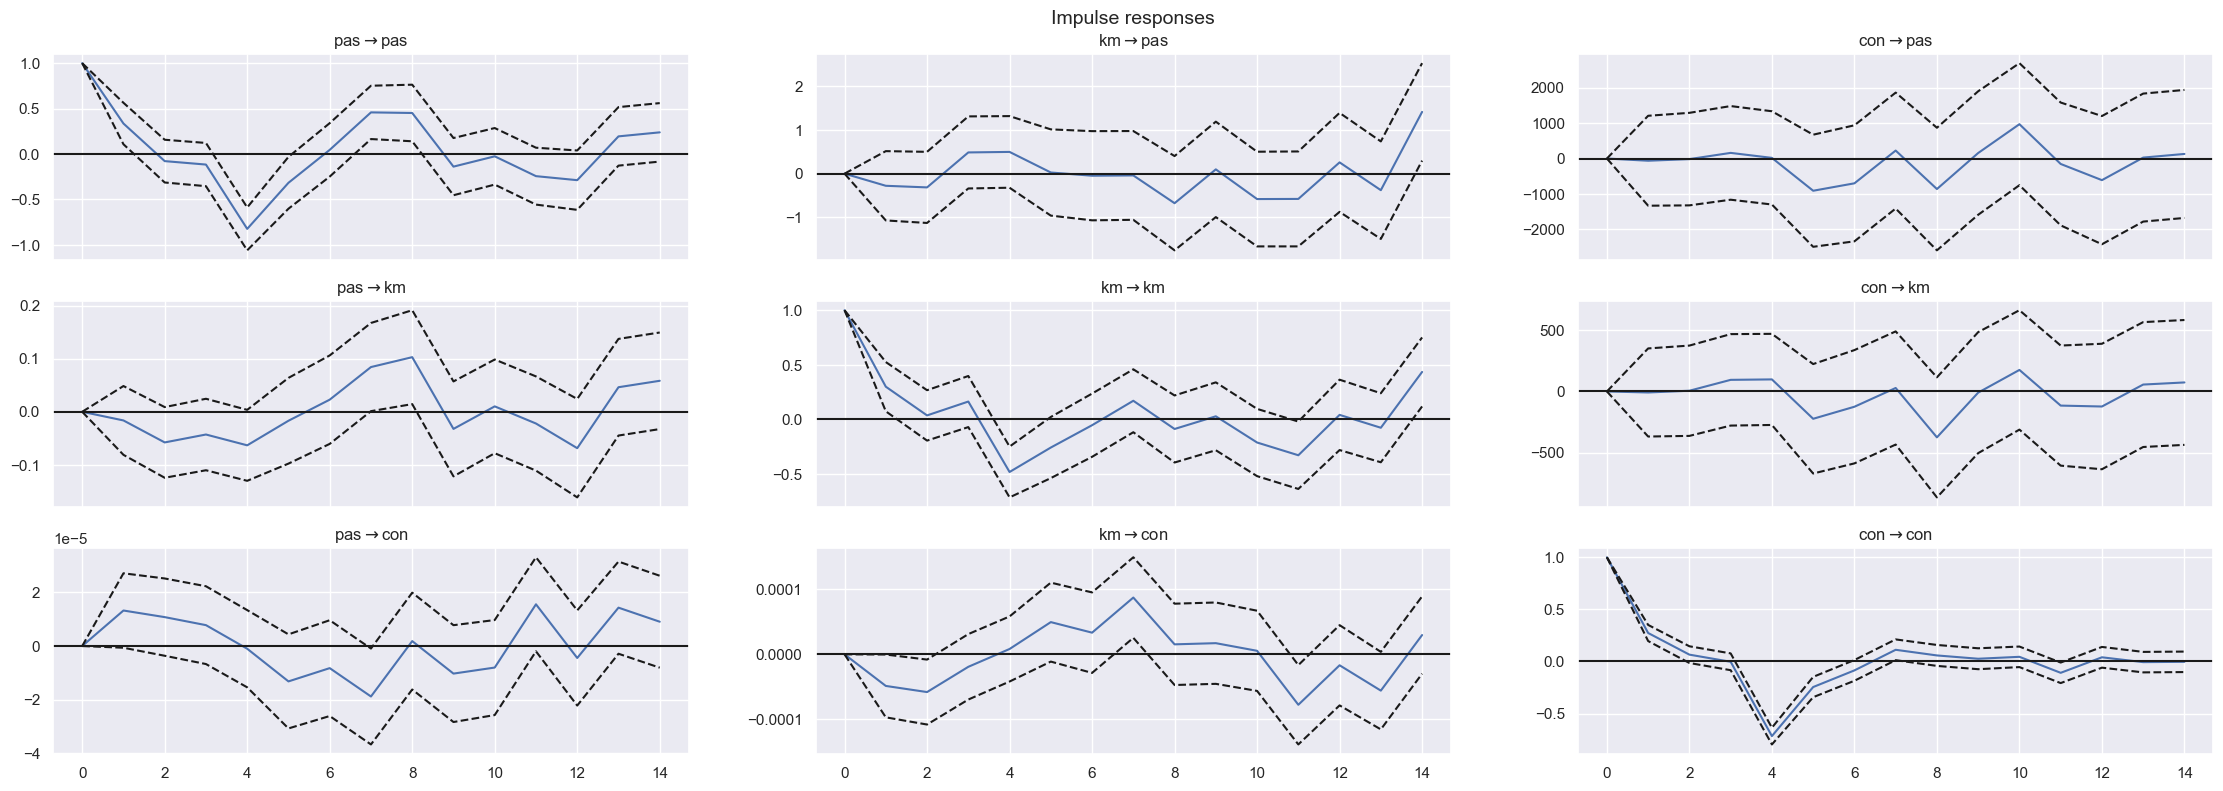

In [22]:
# Impulse response function for the model we trained
irf = model_fitted.irf(periods=14)
irf.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

In [5]:
# Reentrenar el modelo con todos los datos disponibles
import statsmodels.api as sm

# Crear un nuevo modelo SARIMA utilizando todos los datos
nuevo_modelo = sm.tsa.SARIMAX(km_d, order=(0,1,2), seasonal_order=(1,0,1,7)).fit()

# Imprimir el resumen del nuevo modelo
print(nuevo_modelo.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                  km   No. Observations:                  760
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -8191.230
Date:                             Mon, 11 Dec 2023   AIC                          16392.459
Time:                                     00:35:16   BIC                          16415.619
Sample:                                 10-01-2021   HQIC                         16401.378
                                      - 10-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6487      0.025    -26.262      0.000      -0.697      -0.600
ma.L2         -0.2618      

In [6]:
# Se considera una semana del mes de Noviembre del 2023
fechas_prediccion = pd.date_range(start='2023-11-01', end='2023-11-07', freq='D')

# Utilizar el modelo para hacer predicciones
predicciones = nuevo_modelo.get_prediction(start=fechas_prediccion[0], end=fechas_prediccion[-1], dynamic=False)

# Extraer los valores predichos y los intervalos de confianza
prediccion_media = predicciones.predicted_mean
intervalo_confianza = predicciones.conf_int()

# Imprimir los resultados
resultados = pd.DataFrame({'Prediccion': prediccion_media, 'Intervalo de Confianza': intervalo_confianza.values.tolist()}, index=fechas_prediccion)
print(resultados)

              Prediccion                   Intervalo de Confianza
2023-11-01  98670.652472  [74637.34625509862, 122703.95868819032]
2023-11-02  97361.387627  [73242.73936911239, 121480.03588412024]
2023-11-03  94585.322493   [70381.48493375813, 118789.1600529351]
2023-11-04  67802.885133  [43514.156178389305, 92091.61408832559]
2023-11-05  52426.340043  [28053.015364200175, 76799.66472125307]
2023-11-06  94583.121020  [70125.49322142499, 119040.74881809237]
2023-11-07  98061.831678   [73497.8713485441, 122625.79200736967]
